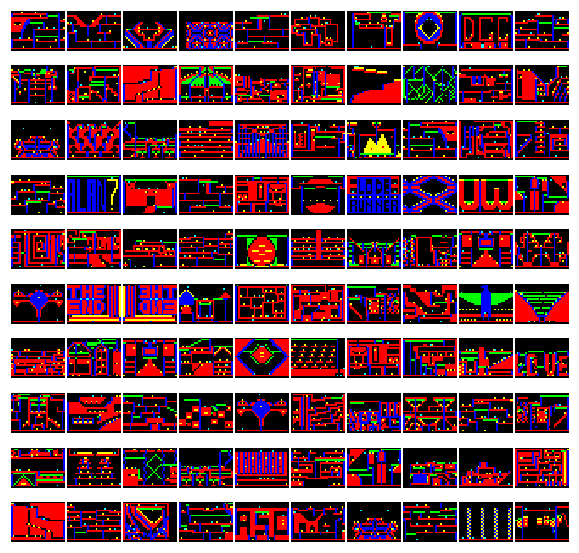

(300, 24, 32, 5)


In [8]:
from __future__ import print_function,division
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import astar

#VAE param
input_path = 'e://python3/cv/levels/lode_runner_5_channel.npy'
gb_w, gb_h, gb_c = 24,32,5
tdata='level'  #level(22*32)*b=1 or mnist(28*28)*b=16
batch_size = 30
total_data = 300
threthod = 0.3
noise_dim = 16   #important part
lr = 1e-3
show_every_img=1000
print_every_loss=100
num_epoch=1000



def translate(images_in):
    images = np.zeros((images_in.shape[0],images_in.shape[1],images_in.shape[2],3),dtype=np.float)
    #R
    images[:,:,:,0] = images_in[:,:,:,0]
    #G
    images[:,:,:,1] = images_in[:,:,:,1]
    #B
    images[:,:,:,2] = images_in[:,:,:,2]
    #yellow
    if gb_c > 3:
        images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([0],dtype=np.int64)])] = 1
        images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([1],dtype=np.int64)])] = 1
    #cyan
    if gb_c > 4:
        images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([1],dtype=np.int64)])] = 1
        images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([2],dtype=np.int64)])] = 1
    return images

def disp_images(images,figsize=None):
    images_sv = np.reshape(images,[-1,gb_w,gb_h,gb_c])
    outlist = images_sv
    images = translate(images_sv)
    images = np.reshape(images,[images.shape[0],-1])
    if threthod!=None:
        images[images>=threthod] = 1.0
        images[images<threthod] = 0.0
    sqrtn = min(int(np.ceil(np.sqrt(images.shape[0]))),10)
    if figsize:
        plt.figure(figsize = figsize)
    else:
        figure = plt.figure(figsize = (sqrtn,sqrtn))
    gs = gridspec.GridSpec(sqrtn,sqrtn)
    gs.update(wspace = 0.05,hspace = 0.05)
    for i,img in enumerate(images):
        tmp = img.reshape([gb_w,gb_h,3])
        if i<100:
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')            
            plt.imshow(tmp) #
    plt.show()
    return outlist


def preprocess(x):
    return 2*x-1.0
def deprocess(x):
    return (x+1.0) / 2.0

def session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config = config)
    return session
def activation(x, alpha = 0.01):# leaky relu
    a = tf.maximum(x,alpha*x)
    return a

def get_solvers(lr = 1e-3, beta1 = 0.5):
    d_solver = tf.train.AdamOptimizer(learning_rate = lr,beta1 = beta1)
    return d_solver

def threthod_func(tin,threthod = 0.5):
    one = tf.ones_like(tin)
    zero = tf.zeros_like(tin)
    tin = tf.where(tin < threthod, x=zero, y=one)
    return tin

def data_augumentation(tin):
    return tin[:,:,::-1,:]

class batch_iter:
    def __init__(self,data,batch_size):
        self.data = data.reshape([data.shape[0],-1])
        self.batch_size = batch_size
        self.iter = 0
    def next_batch(self):
        if self.iter>=len(self.data): 
            np.random.shuffle(self.data)        
            self.iter = 0
        tmp = self.iter
        self.iter += self.batch_size
        return self.data[tmp:tmp+batch_size]

if tdata == 'level':
    imageMatrix1 = np.load(input_path)[:150]
    imageMatrix2 = data_augumentation(imageMatrix1)
    imageMatrix1 = np.vstack((imageMatrix1,imageMatrix2))
    np.random.shuffle(imageMatrix1)
    imageMatrix1 = imageMatrix1[0:total_data]  #----------------------------------
    disp_images(imageMatrix1)
    print(imageMatrix1.shape)
    '''path = "e://python3/cv/"
    file1="shang.png"#"2.jpg"#"chang.png""checker128-var20.png"
    img1 = Image.open(path+str(file1)) 
    imageMatrix1 = np.matrix(img1.getdata())
    def grey_kernel(matrix,L):
        new = np.zeros(matrix.shape[0])
        for i in range(matrix.shape[0]):
            new[i]=np.uint8(round(0.299*matrix[i,0]+0.587*matrix[i,1]+0.114*matrix[i,2]))#matrix[i,0]#      
        return new
    imageMatrix1 = grey_kernel(imageMatrix1,256)
    imageMatrix1 = np.reshape(imageMatrix1,[1,-1])
    disp_images(imageMatrix1)
    print(imageMatrix1.shape)'''
if tdata == 'mnist':
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets('MNIST_data',one_hot = False)
    disp_images(mnist.train.next_batch(16)[0])# [0] stands for batch x, [1] stands for batch y
    print(mnist.train.next_batch(16)[0].shape) #one global para 12
    print(type(mnist))


In [9]:
def gaussian_MLP_encoder(x_in): #input should be with intensity 0~1
    with tf.variable_scope("encoder"):
        init = tf.contrib.layers.xavier_initializer()
        x_in = preprocess(x_in)
        fc1 = tf.layers.dense(inputs=x_in,units=max(gb_w,gb_h)**2*gb_c, #batch*32*32*3
                              activation=tf.nn.relu,kernel_initializer = init,name='dense_0')
        
        cv2 = fc1
        fc1 = tf.reshape(fc1,[-1,max(gb_w,gb_h),max(gb_w,gb_h),gb_c])
        
        cv1 = tf.layers.conv2d(fc1,8,4,strides=2,padding='same',  #batch*16*16*8
                            kernel_initializer=init,name='e_conv_1')
        cv1 = tf.layers.batch_normalization(cv1,name='e_batchnorm_1')
        cv1 = activation(cv1) 
        cv2 = tf.layers.conv2d(cv1,16,4,strides=2,padding='same',  #batch*8*8*16
                            kernel_initializer=init,name='e_conv_2')
        cv2 = tf.layers.batch_normalization(cv2,name='e_batchnorm_2')
        cv2 = activation(cv2) 
        cv2 = tf.reshape(cv2,[-1,8*8*16])
        
        '''cv2 = tf.nn.dropout(cv2,keep_prob=0.5)'''
        gaussian_params = tf.layers.dense(inputs=cv2,units=noise_dim*2,
                                          kernel_initializer = init,name='dense_3')
        n_output = gaussian_params.shape[1]//2
        mean = gaussian_params[:,:n_output]
        stddev = 1e-6 + tf.nn.softplus(gaussian_params[:,n_output:])
        return mean, stddev
def bernoulli_MLP_decoder(z_in):
    with tf.variable_scope("decoder"):
        init = tf.contrib.layers.xavier_initializer()
        '''z_in = tf.nn.dropout(z_in,keep_prob=0.5)'''
        fc1 = tf.layers.dense(inputs=z_in,units=8*8*16,activation=tf.nn.relu,kernel_initializer = init,name='dense_11')
        
        
        fc1 = tf.reshape(fc1,[-1,8,8,16]) 
        
        cv1 = tf.layers.conv2d_transpose(fc1,filters=8,kernel_size=4,strides=2,padding='same', #batch*16*16*8
                                                kernel_initializer=init,name='d_deconv_1')
        cv1 = tf.layers.batch_normalization(cv1,name='d_batchnorm_1')
        cv1 = tf.nn.relu(cv1)
        
        cv2 = tf.layers.conv2d_transpose(cv1,filters=gb_c,kernel_size=4,strides=2,padding='same', #batch*32*32*3
                                                kernel_initializer=init,name='d_deconv_2')
        cv2 = tf.layers.batch_normalization(cv2,name='d_batchnorm_2')
        cv2 = tf.nn.relu(cv2)        
        cv2 = tf.reshape(cv2,[-1,max(gb_w,gb_h)**2*gb_c]) 
        
        
        fc2 = tf.layers.dense(inputs=cv2,units=gb_w*gb_h*gb_c,
                              kernel_initializer = init,name='dense_00') #11111
        fc2 = tf.nn.sigmoid(fc2)

        #fc2 = threthod_func(fc2,threthod = 0.5)
        return fc2  #output is with intensity 0~1

     
def autoencoder(x):
    with tf.variable_scope("autoencoder"):
        mu, sigma = gaussian_MLP_encoder(x)
        z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)
        #z = tf.nn.tanh(z)
        y = bernoulli_MLP_decoder(z)
        marginal_likelihood = tf.reduce_sum(x*tf.log(1e-6+y)+(1-x)*tf.log(1e-6+1-y),1)
        KL_divergence = 10*0.5 * tf.reduce_sum(tf.square(mu)+tf.square(sigma) - tf.log(1e-8 + tf.square(sigma))-1, 1)

        ELBO = tf.reduce_mean(marginal_likelihood) - tf.reduce_mean(KL_divergence)
        loss = -ELBO

        return y, z, loss, -tf.reduce_mean(marginal_likelihood), tf.reduce_mean(KL_divergence),mu,sigma
    
def train(sess,D_train_step,D_loss,show_every=50,print_every=10,batch_size=1,num_epoch=10):
    if tdata=='level':
        come_in_data = imageMatrix1 #np.random.uniform(0,1,size=[1,22*32]) 
        data = batch_iter(come_in_data,batch_size)
        max_iter = int(len(data.data)*num_epoch/batch_size)
    elif tdata=='mnist':
        max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        if it and (it % show_every == 0):
            print('generated img')
            sap_noise = np.random.normal(0, 1,[16,noise_dim])
            samples = sess.run(output_real, feed_dict = {latent: sap_noise})
            fig = disp_images(samples[:batch_size if batch_size<16 else 16])# one global para

            print()
        #fetch the minibatch and train
        if tdata=='level':
            minibatch = data.next_batch()
        elif tdata=='mnist':
            minibatch,_ = mnist.train.next_batch(batch_size)
        
        _,D_loss_curr,opr,tml,tkl,m,s = sess.run([D_train_step,D_loss,output_real,ml,kl,mu,sigma],feed_dict = {x:minibatch})
        if D_loss_curr<-(10e5): break  
        if it and (it % show_every == 0):
            print('test img')            
            disp_images(opr[:batch_size if batch_size<16 else 16])  # one global para
   
        if (it % print_every == 0):
            print('Iter:{}, loss:{:.4}'.format(it,D_loss_curr))
            print('   encoder_loss:{:.4}, decoder_loss:{:.4}'.format(tml,tkl))


    print('Final images')
    sap_noise = np.random.normal(0, 1,[100,noise_dim])
    samples = sess.run(output_real, feed_dict = {latent: sap_noise})
    fig = disp_images(samples)# one global para

Iter:0, loss:2.693e+03
   encoder_loss:2.661e+03, decoder_loss:31.68
Iter:100, loss:846.4
   encoder_loss:842.1, decoder_loss:4.329
Iter:200, loss:788.1
   encoder_loss:773.6, decoder_loss:14.53
Iter:300, loss:779.8
   encoder_loss:758.7, decoder_loss:21.15
Iter:400, loss:815.8
   encoder_loss:790.0, decoder_loss:25.82
Iter:500, loss:783.5
   encoder_loss:751.6, decoder_loss:31.9
Iter:600, loss:741.2
   encoder_loss:699.2, decoder_loss:41.98
Iter:700, loss:737.9
   encoder_loss:684.9, decoder_loss:52.98
Iter:800, loss:648.0
   encoder_loss:587.1, decoder_loss:60.93
Iter:900, loss:641.1
   encoder_loss:572.3, decoder_loss:68.84
generated img


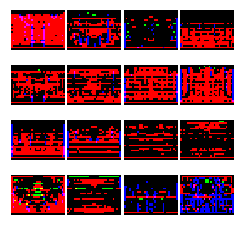


test img


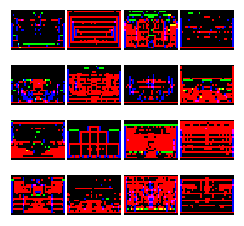

Iter:1000, loss:562.4
   encoder_loss:467.6, decoder_loss:94.82
Iter:1100, loss:617.7
   encoder_loss:525.1, decoder_loss:92.6
Iter:1200, loss:529.1
   encoder_loss:419.5, decoder_loss:109.6
Iter:1300, loss:384.4
   encoder_loss:264.2, decoder_loss:120.2
Iter:1400, loss:375.5
   encoder_loss:246.3, decoder_loss:129.2
Iter:1500, loss:336.2
   encoder_loss:197.6, decoder_loss:138.6
Iter:1600, loss:253.8
   encoder_loss:107.7, decoder_loss:146.1
Iter:1700, loss:269.0
   encoder_loss:129.3, decoder_loss:139.7
Iter:1800, loss:178.7
   encoder_loss:37.35, decoder_loss:141.4
Iter:1900, loss:174.8
   encoder_loss:47.77, decoder_loss:127.1
generated img


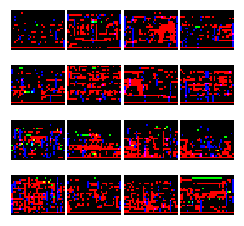


test img


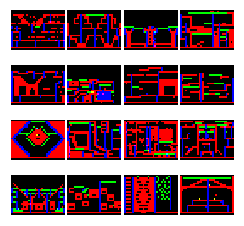

Iter:2000, loss:166.8
   encoder_loss:28.69, decoder_loss:138.1
Iter:2100, loss:192.6
   encoder_loss:40.79, decoder_loss:151.9
Iter:2200, loss:187.6
   encoder_loss:54.34, decoder_loss:133.3
Iter:2300, loss:137.8
   encoder_loss:13.35, decoder_loss:124.5
Iter:2400, loss:154.7
   encoder_loss:12.01, decoder_loss:142.6
Iter:2500, loss:162.7
   encoder_loss:37.11, decoder_loss:125.6
Iter:2600, loss:181.6
   encoder_loss:38.38, decoder_loss:143.2
Iter:2700, loss:172.6
   encoder_loss:54.9, decoder_loss:117.7
Iter:2800, loss:560.6
   encoder_loss:434.5, decoder_loss:126.1
Iter:2900, loss:159.5
   encoder_loss:22.9, decoder_loss:136.6
generated img


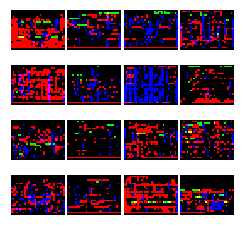


test img


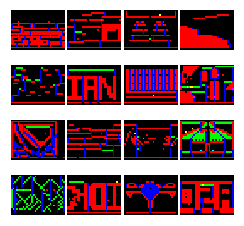

Iter:3000, loss:143.8
   encoder_loss:17.72, decoder_loss:126.1
Iter:3100, loss:154.8
   encoder_loss:22.86, decoder_loss:131.9
Iter:3200, loss:146.2
   encoder_loss:22.21, decoder_loss:124.0
Iter:3300, loss:136.7
   encoder_loss:20.47, decoder_loss:116.2
Iter:3400, loss:126.3
   encoder_loss:8.476, decoder_loss:117.8
Iter:3500, loss:146.6
   encoder_loss:8.845, decoder_loss:137.8
Iter:3600, loss:144.7
   encoder_loss:20.3, decoder_loss:124.4
Iter:3700, loss:151.0
   encoder_loss:41.32, decoder_loss:109.6
Iter:3800, loss:149.0
   encoder_loss:32.07, decoder_loss:117.0
Iter:3900, loss:136.0
   encoder_loss:18.01, decoder_loss:118.0
generated img


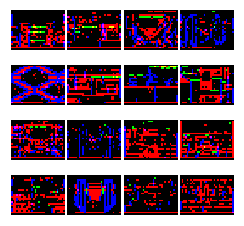


test img


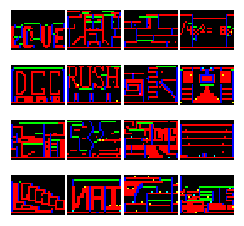

Iter:4000, loss:143.6
   encoder_loss:13.96, decoder_loss:129.7
Iter:4100, loss:150.1
   encoder_loss:23.06, decoder_loss:127.1
Iter:4200, loss:144.9
   encoder_loss:26.52, decoder_loss:118.4
Iter:4300, loss:171.5
   encoder_loss:33.02, decoder_loss:138.4
Iter:4400, loss:125.4
   encoder_loss:8.925, decoder_loss:116.5
Iter:4500, loss:323.4
   encoder_loss:178.1, decoder_loss:145.3
Iter:4600, loss:147.0
   encoder_loss:28.52, decoder_loss:118.5
Iter:4700, loss:129.7
   encoder_loss:8.674, decoder_loss:121.0
Iter:4800, loss:128.8
   encoder_loss:10.3, decoder_loss:118.5
Iter:4900, loss:128.6
   encoder_loss:17.17, decoder_loss:111.4
generated img


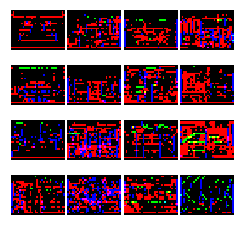


test img


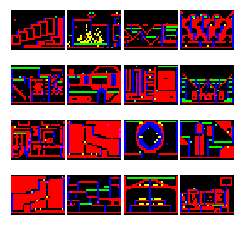

Iter:5000, loss:137.4
   encoder_loss:16.51, decoder_loss:120.9
Iter:5100, loss:140.0
   encoder_loss:3.296, decoder_loss:136.7
Iter:5200, loss:133.2
   encoder_loss:16.85, decoder_loss:116.4
Iter:5300, loss:135.3
   encoder_loss:20.94, decoder_loss:114.4
Iter:5400, loss:144.2
   encoder_loss:30.25, decoder_loss:114.0
Iter:5500, loss:130.5
   encoder_loss:7.736, decoder_loss:122.7
Iter:5600, loss:133.9
   encoder_loss:11.31, decoder_loss:122.6
Iter:5700, loss:126.8
   encoder_loss:8.019, decoder_loss:118.8
Iter:5800, loss:156.5
   encoder_loss:31.92, decoder_loss:124.6
Iter:5900, loss:124.5
   encoder_loss:6.368, decoder_loss:118.2
generated img


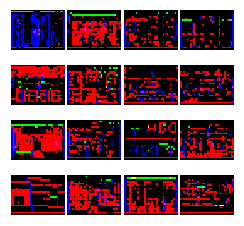


test img


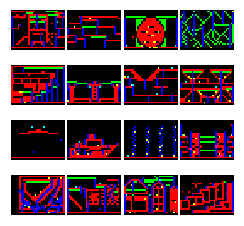

Iter:6000, loss:135.9
   encoder_loss:21.49, decoder_loss:114.4
Iter:6100, loss:141.6
   encoder_loss:20.54, decoder_loss:121.1
Iter:6200, loss:122.8
   encoder_loss:8.088, decoder_loss:114.7
Iter:6300, loss:127.8
   encoder_loss:8.203, decoder_loss:119.6
Iter:6400, loss:119.2
   encoder_loss:14.67, decoder_loss:104.5
Iter:6500, loss:125.5
   encoder_loss:4.613, decoder_loss:120.9
Iter:6600, loss:138.2
   encoder_loss:4.039, decoder_loss:134.1
Iter:6700, loss:120.3
   encoder_loss:7.559, decoder_loss:112.8
Iter:6800, loss:121.4
   encoder_loss:9.486, decoder_loss:111.9
Iter:6900, loss:147.1
   encoder_loss:15.28, decoder_loss:131.8
generated img


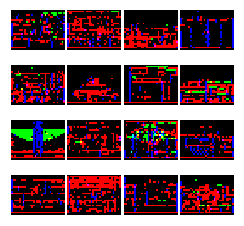


test img


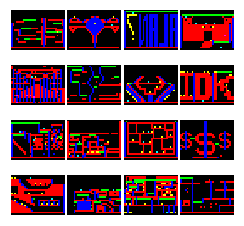

Iter:7000, loss:125.0
   encoder_loss:6.288, decoder_loss:118.7
Iter:7100, loss:128.5
   encoder_loss:6.104, decoder_loss:122.4
Iter:7200, loss:117.4
   encoder_loss:5.991, decoder_loss:111.4
Iter:7300, loss:127.3
   encoder_loss:17.31, decoder_loss:110.0
Iter:7400, loss:159.3
   encoder_loss:16.27, decoder_loss:143.0
Iter:7500, loss:126.3
   encoder_loss:6.317, decoder_loss:120.0
Iter:7600, loss:116.6
   encoder_loss:5.128, decoder_loss:111.5
Iter:7700, loss:133.0
   encoder_loss:7.579, decoder_loss:125.4
Iter:7800, loss:126.5
   encoder_loss:7.078, decoder_loss:119.4
Iter:7900, loss:193.9
   encoder_loss:34.06, decoder_loss:159.9
generated img


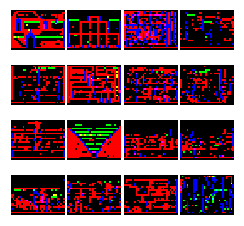


test img


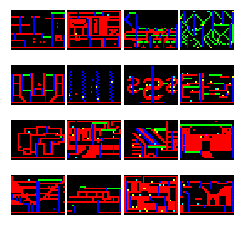

Iter:8000, loss:129.2
   encoder_loss:19.24, decoder_loss:109.9
Iter:8100, loss:121.3
   encoder_loss:8.043, decoder_loss:113.2
Iter:8200, loss:133.3
   encoder_loss:17.57, decoder_loss:115.7
Iter:8300, loss:128.9
   encoder_loss:14.05, decoder_loss:114.9
Iter:8400, loss:132.8
   encoder_loss:14.78, decoder_loss:118.0
Iter:8500, loss:116.3
   encoder_loss:5.56, decoder_loss:110.7
Iter:8600, loss:127.9
   encoder_loss:7.718, decoder_loss:120.1
Iter:8700, loss:160.5
   encoder_loss:41.84, decoder_loss:118.6
Iter:8800, loss:137.5
   encoder_loss:13.75, decoder_loss:123.7
Iter:8900, loss:152.8
   encoder_loss:17.1, decoder_loss:135.7
generated img


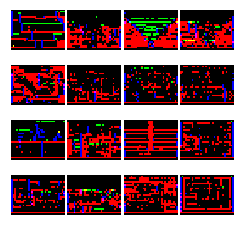


test img


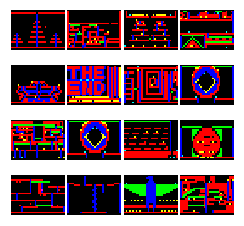

Iter:9000, loss:122.1
   encoder_loss:3.137, decoder_loss:119.0
Iter:9100, loss:126.0
   encoder_loss:13.51, decoder_loss:112.4
Iter:9200, loss:112.7
   encoder_loss:9.174, decoder_loss:103.5
Iter:9300, loss:133.2
   encoder_loss:14.84, decoder_loss:118.3
Iter:9400, loss:122.8
   encoder_loss:11.7, decoder_loss:111.1
Iter:9500, loss:114.5
   encoder_loss:2.245, decoder_loss:112.3
Iter:9600, loss:143.1
   encoder_loss:26.25, decoder_loss:116.8
Iter:9700, loss:119.3
   encoder_loss:7.695, decoder_loss:111.6
Iter:9800, loss:127.7
   encoder_loss:4.701, decoder_loss:123.0
Iter:9900, loss:120.8
   encoder_loss:11.72, decoder_loss:109.1
Final images


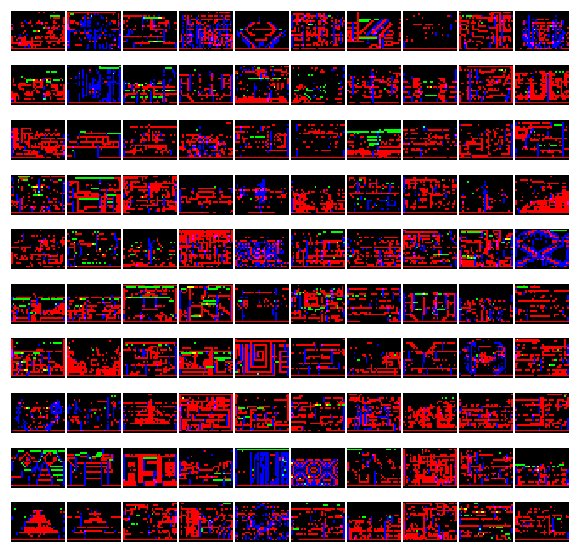

In [10]:
tf.reset_default_graph()
#batch_size = 16
#noise_dim = 50   #important part
x = tf.placeholder(tf.float32,[None,gb_w*gb_h*gb_c]) #-----------------------------------------

output_real, latent, d_loss, ml, kl, mu, sigma = autoencoder(x)


d_solver = get_solvers(lr=lr)
d_train_step = d_solver.minimize(d_loss)

sess = session()
try:
    with tf.device("/cpu:0") as dev:
        sess.run(tf.global_variables_initializer())
        train(sess,d_train_step,d_loss,show_every=show_every_img,print_every=print_every_loss,batch_size=batch_size, num_epoch=num_epoch)    
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration") 

    


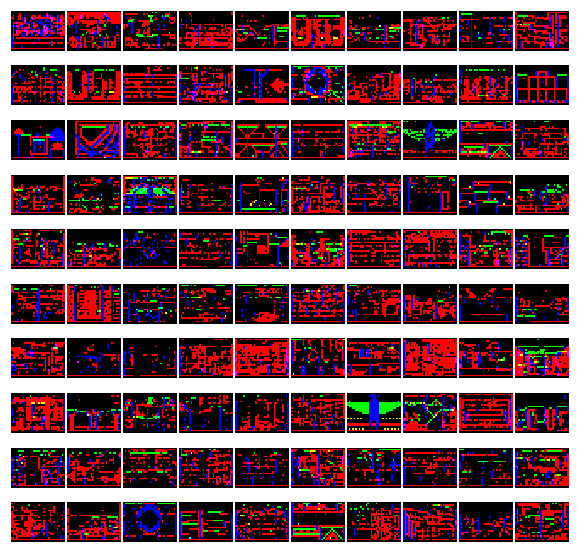

(10000, 24, 32, 5)


In [11]:
generate_num = 9700
sap_noise = np.random.normal(0, 1,[generate_num,noise_dim])
samples = sess.run(output_real, feed_dict = {latent: sap_noise})
fig = disp_images(samples)# one global para\
img_save = np.vstack((fig,imageMatrix1))
np.random.shuffle(img_save)
np.save("vae_v3",img_save,allow_pickle=False,fix_imports=True)
sth = np.load("e://python3/vae_v3.npy")

print(sth.shape)

In [12]:
#sess.close()

In [13]:
#----evolution
class Util:
    def img2gene(level_in):  #[150,22,32,3]
        #if not level_in: return 'error'
        gene = level_in.reshape([level_in.shape[0],-1])
        return gene  #output 150,22*32,3
    def translate(images_in):
        images = np.zeros((images_in.shape[0],images_in.shape[1],images_in.shape[2],3),dtype=np.float)
        #R
        images[:,:,:,0] = images_in[:,:,:,0]
        #G
        images[:,:,:,1] = images_in[:,:,:,1]
        #B
        images[:,:,:,2] = images_in[:,:,:,2]
        #yellow
        if gb_c > 3:
            images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([0],dtype=np.int64)])] = 1
            images[tuple(list(np.where(images_in[:,:,:,3]==1))+[np.array([1],dtype=np.int64)])] = 1
        #cyan
        if gb_c > 4:
            images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([1],dtype=np.int64)])] = 1
            images[tuple(list(np.where(images_in[:,:,:,4]==1))+[np.array([2],dtype=np.int64)])] = 1
        return images

    def disp_images(images,threthod=0.3,figsize=None,gb_w=gb_w,gb_h=gb_h,gb_c=gb_c):
        images_sv = np.reshape(images,[-1,gb_w,gb_h,gb_c])
        outlist = images_sv
        images = Util.translate(images_sv)
        images = np.reshape(images,[images.shape[0],-1])
        if threthod!=None:
            images[images>=threthod] = 1.0
            images[images<threthod] = 0.0
        sqrtn = min(int(np.ceil(np.sqrt(images.shape[0]))),10)
        if figsize:
            plt.figure(figsize = figsize)
        else:
            figure = plt.figure(figsize = (sqrtn,sqrtn))
        gs = gridspec.GridSpec(sqrtn,sqrtn)
        gs.update(wspace = 0.05,hspace = 0.05)
        for i,img in enumerate(images):
            tmp = img.reshape([gb_w,gb_h,3])
            if i<100:
                ax = plt.subplot(gs[i])
                plt.axis('off')
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_aspect('equal')            
                plt.imshow(tmp) #
        plt.show()  
    def encoding_img(np_in):
        np_in = np_in.reshape([gb_w,gb_h,-1])
        a = np.zeros(np_in.shape)
        b = np.where(np_in[:,:,0] > 0.5, 1, 0)
        c = np.where(np_in[:,:,1] > 0.5, 5, 0)
        d = np.where(np_in[:,:,2] > 0.5, 10, 0)
        e = b + c + d
        if gb_c > 3:
            bb = np.where(np_in[:,:,3] > 0.5, 50, 0)
            e = e + bb
        if gb_c > 4:
            cc = np.where(np_in[:,:,4] > 0.5, 100, 0)
            e = e + cc
        
        f = np.zeros(e.shape)
        f = f.astype('str')
        
        
        f[np.where(e==0)] = '.'
        if list(np.where(e==0)): 
            f[(np.array([np.where(e==0)[0][0]]),np.array([np.where(e==0)[1][0]]))] = 'M'
        
        condb = np.where((e>0) & (e<5))
        f[condb] = 'b'
        a[(condb[0],condb[1],0*np.ones(len(condb[0]),dtype=np.int64))] = 1
        
        condr = np.where((e>4) & (e<10))
        f[condr] = '-'
        a[(condr[0],condr[1],1*np.ones(len(condr[0]),dtype=np.int64))] = 1
        
        condl = np.where((e>9) & (e<50))
        f[condl] = '#'
        a[(condl[0],condl[1],2*np.ones(len(condl[0]),dtype=np.int64))] = 1
        
        if gb_c > 3:
            condg = np.where((e>49) & (e<100))
            f[condg] = 'G'
            a[(condg[0],condg[1],3*np.ones(len(condg[0]),dtype=np.int64))] = 1
            
        if gb_c > 4:
            conde = np.where(e>99)
            f[conde] = 'E'
            a[(conde[0],conde[1],4*np.ones(len(conde[0]),dtype=np.int64))] = 1        

        '''
        st_lock = None
        for i in range(gb_w):
            for j in range(gb_h):
                if e[i][j] == 0:
                    f[i][j] = "."
                    if st_lock == None:
                        f[i][j] = 'M'
                        st_lock = True
                        
                if (e[i][j] > 0 and e[i][j] < 5):
                    f[i][j] = "b"
                    a[i][j][0] = 1
                if  (e[i][j] > 4 and e[i][j] < 10):
                    f[i][j] = "-"
                    a[i][j][1] = 1
                if e[i][j] > 9:
                    f[i][j] = "#"
                    a[i][j][2] = 1
        if not st_lock: f[0][0] = 'M'#'''
        np_in = np_in.reshape([-1])
        a = a.reshape([-1])
        f = list(f)
        return f, a       
    def fitness(population):
        output = []
        refined_imglist = []
        for i in range(population.shape[0]):
            #print('process ',i)
            img_each, refined_img  = Util.encoding_img(population[i])
            score = astar.Astar(img_each)
            output.append(score)
            refined_imglist.append(refined_img)
        return np.array(output), np.array(refined_imglist)#np.random.rand(len(data))#output[150,1]     
    
class Generic:
    def __init__(self,data,rawset,crossover_rate=1.0,mutate_rate = 0.25,n_population = 15,
                 DNA_size=gb_w*gb_h*gb_c,n_iterations = 3): #[150,704*3]
        self.rawset = rawset
        print(self.rawset.shape)
        self.population = data
        self.crossover_rate = crossover_rate
        self.mutate_rate = mutate_rate
        self.n_population = n_population
        self.DNA_size = DNA_size
        self.n_iterations = n_iterations
        
    def fitness(self,population):
        output = []
        refined_imglist = []
        for i in range(population.shape[0]):
            #print('process ',i)
            img_each, refined_img  = Util.encoding_img(population[i])
            score = astar.Astar(img_each)
            output.append(score)
            refined_imglist.append(refined_img)
        return np.array(output), np.array(refined_imglist)#np.random.rand(len(data))#output[150,1]     

    def select(self,population,fitness_score):
        fitness_score = fitness_score + 1e-4
        idx = np.random.choice(np.arange(population.shape[0]), size=self.n_population, replace=False,
                               p=fitness_score/fitness_score.sum())
        return population[idx], fitness_score[idx]
   
    def create_child(self,idx_p,parent,pop): #[1,704*3], [150,704*3]
        index = np.random.randint(0,pop.shape[0],size=1)
        if index != idx_p:
            if np.random.rand()<self.crossover_rate:
                parent, same = self.segment_mask_inheret(parent,pop[index],partition=2)       
                return parent, same
            else:
                return parent, 'same'
        else:
            return parent,'same'

    def mutate_child(self, child):
        #child, same = self.segment_mask_mutate(child)
        same = 'same'  
        if np.random.rand()<self.mutate_rate:
            op_real = sess.run(output_real,feed_dict = {x:child.reshape([1,-1])})
            same = 'different'
            child = op_real[0].reshape([gb_w,gb_h,gb_c])
        return child, same
    
    def segment_mask_inheret(self,data_a,data_b,partition=1):#[22,32,3]
        data_a = data_a.reshape([gb_w,gb_h,-1])
        data_b = data_b.reshape([gb_w,gb_h,-1])
        child = np.zeros(data_a.shape)
        mask = np.random.randint(0,2,size=(partition+1,partition+1)).astype(np.bool)
        sp_i = random.randint(0,gb_w)
        sp_j = random.randint(0,gb_h)
        same = ''
        if partition==2:
            sp_ii, sp_jj = sp_i, sp_j
            while sp_ii == sp_i:
                sp_ii = random.randint(0,gb_w)
            while sp_jj == sp_j:
                sp_jj = random.randint(0,gb_h)
            sp_i, sp_ii = (sp_i, sp_ii) if sp_i<sp_ii else (sp_ii,sp_i)
            sp_j, sp_jj = (sp_j, sp_jj) if sp_j<sp_jj else (sp_jj,sp_j)
        if partition == 1:
            child[:sp_i,:sp_j,:] = data_a[:sp_i,:sp_j,:] if mask[0][0]==1 else data_b[:sp_i,:sp_j,:] #1
            child[sp_i:,:sp_j,:] = data_a[sp_i:,:sp_j,:] if mask[1][0]==1 else data_b[sp_i:,:sp_j,:] #2
            child[:sp_i,sp_j:,:] = data_a[:sp_i,sp_j:,:] if mask[0][1]==1 else data_b[:sp_i,sp_j:,:] #3
            child[sp_i:,sp_j:,:] = data_a[sp_i:,sp_j:,:] if mask[1][1]==1 else data_b[sp_i:,sp_j:,:] #4
            same = 'different' if (mask[0][0] or mask[1][0] or mask[0][1] or mask[1][1]) else 'same'
        if partition==2:
            child[:sp_i,:sp_j,:] = data_a[:sp_i,:sp_j,:] if mask[0][0]==1 else data_b[:sp_i,:sp_j,:] #1
            child[:sp_i,sp_j:sp_jj,:] = data_a[:sp_i,sp_j:sp_jj,:] if mask[0][1]==1 else data_b[:sp_i,sp_j:sp_jj,:] #2
            child[:sp_i,sp_jj:,:] = data_a[:sp_i,sp_jj:,:] if mask[0][2]==1 else data_b[:sp_i,sp_jj:,:] #3
            child[sp_i:sp_ii,:sp_j,:] = data_a[sp_i:sp_ii,:sp_j,:] if mask[1][0]==1 else data_b[sp_i:sp_ii,:sp_j,:] #4
            
            child[sp_i:sp_ii,sp_j:sp_jj,:] = data_a[sp_i:sp_ii,sp_j:sp_jj,:] if mask[1][1]==1 else data_b[sp_i:sp_ii,sp_j:sp_jj,:] #5
            child[sp_i:sp_ii,sp_jj:,:] = data_a[sp_i:sp_ii,sp_jj:,:] if mask[1][2]==1 else data_b[sp_i:sp_ii,sp_jj:,:] #6
            child[sp_ii:,:sp_j,:] = data_a[sp_ii:,:sp_j,:] if mask[2][0]==1 else data_b[sp_ii:,:sp_j,:] #7
            child[sp_ii:,sp_j:sp_jj,:] = data_a[sp_ii:,sp_j:sp_jj,:] if mask[2][2]==1 else data_b[sp_ii:,sp_j:sp_jj,:] #8 
            child[sp_ii:,sp_jj:,:] = data_a[sp_ii:,sp_jj:,:] if mask[2][1]==1 else data_b[sp_ii:,sp_jj:,:] #9
            same = 'different' if (mask[0][0] or mask[0][1] or mask[0][2] or\
                              mask[1][0] or mask[1][1] or mask[1][2] or\
                               mask[2][0] or mask[2][1] or mask[2][2]) else 'same'  

        child = child.reshape([-1])
        return child, same
    
    def segment_mask_mutate(self,data,partition=1):
        data = data.reshape([gb_w,gb_h,-1])
        child = data
        mask = np.random.rand(partition+1,partition+1)

        sp_i = random.randint(0,gb_w)
        sp_j = random.randint(0,gb_h)
        idx = 0
        same = 'same'
        if mask[0][0]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[:sp_i,:sp_j,:] = self.rawset[idx,:sp_i,:sp_j,:]
        if mask[1][0]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[sp_i:,:sp_j,:] = self.rawset[idx,sp_i:,:sp_j,:]
        if mask[0][1]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[:sp_i,sp_j:,:] = self.rawset[idx,:sp_i,sp_j:,:]
        if mask[1][1]<self.mutate_rate:
            same = 'different'
            idx = np.random.randint(0,self.rawset.shape[0],size=1)
            child[sp_i:,sp_j:,:] = self.rawset[idx,sp_i:,sp_j:,:]
        child = child.reshape([-1])
        return child, same
    
    def evolution(self):
        for i in range(self.n_iterations):
            fitness_score, refined_imglist = self.fitness(self.population)
            self.population = refined_imglist
            self.population, fitness_score = self.select(self.population,fitness_score)
            
            tmp_save = self.population
            best_person = self.population[np.argmax(fitness_score)]
            
            if i%1 == 0:
                print('{} th evolution, score_max:{:.4}, score_min:{:.4},'.format(i, np.max(fitness_score),
                                                                                 np.min(fitness_score)))
                print(fitness_score)
            if i and i%1 == 0:
                Util.disp_images(self.population)
            #if np.min(fitness_score)>0.85: break    
            parent_tmp = list(self.population)
            for idx_p,parent in enumerate(self.population):
                child, same1 = self.create_child(idx_p, parent, self.population)
                child, same2 = self.mutate_child(child) 
                if same1 != 'same' or same2 != 'same':
                    parent_tmp.append(child)
            self.population = np.array(parent_tmp)
        self.population = tmp_save
        self.best_person = best_person

epoch: 0 ,start----------------------------------------------


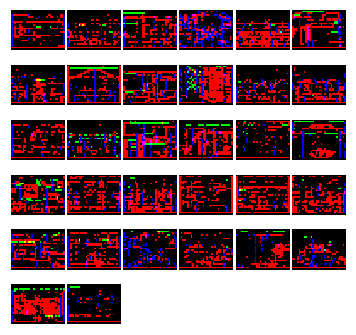

(10000, 24, 32, 5)
0 th evolution, score_max:0.9517, score_min:0.05343,
[0.79720145 0.42317692 0.54771905 0.92483118 0.16893117 0.93113448
 0.1039961  0.2805878  0.34256575 0.38038169 0.19746842 0.31717317
 0.41186471 0.8751     0.12867143 0.28957368 0.60616061 0.9517129
 0.37298136 0.15883016 0.19158936 0.06676667 0.32936829 0.32977033
 0.1126     0.17401304 0.05343333 0.34893721 0.37847838 0.140725
 0.22590645 0.06751573]
1 th evolution, score_max:0.9486, score_min:0.09101,
[0.9201     0.34338358 0.09100909 0.80655161 0.94855361 0.81588947
 0.34577901 0.76325789 0.93912439 0.34187215 0.18471538 0.546975
 0.15883016 0.2973973  0.28215128 0.56588947 0.31588947 0.25311205
 0.4495382  0.69343333 0.34930635 0.10820811 0.14127647 0.33776234
 0.1642791  0.93558387 0.3001     0.1745186  0.23198406 0.8751
 0.49162542 0.48539412]


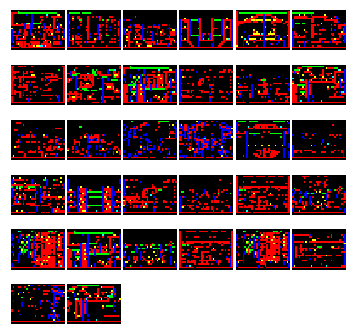

2 th evolution, score_max:0.9126, score_min:0.1325,
[0.55691818 0.76852105 0.13245294 0.6970697  0.33833529 0.67867143
 0.5751     0.44454444 0.5126     0.56174384 0.55138205 0.28581429
 0.36852105 0.34492759 0.9126     0.31828182 0.31717317 0.33343333
 0.90779231 0.84732222 0.76480588 0.53235806 0.85536316 0.58676667
 0.30676667 0.21343333 0.14676667 0.80607015 0.5501     0.89865072
 0.26592278 0.26398889]


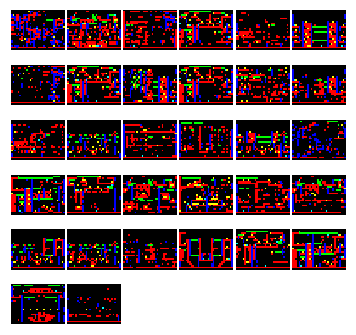

3 th evolution, score_max:0.9404, score_min:0.1352,
[0.84220526 0.7762194  0.81405349 0.65161515 0.28995507 0.2028027
 0.51817229 0.22901566 0.5863069  0.84941507 0.29518197 0.4876
 0.40308507 0.3251     0.56331839 0.69501525 0.79022346 0.86914762
 0.17657059 0.13523514 0.54771905 0.83793784 0.94039851 0.4401
 0.79720145 0.67958718 0.57964545 0.7028027  0.1626     0.50642911
 0.51325789 0.79022346]


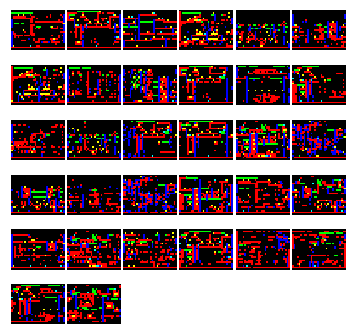

4 th evolution, score_max:0.9232, score_min:0.1853,
[0.85925493 0.4517129  0.18528519 0.55082464 0.77787778 0.265725
 0.5001     0.7751     0.72103023 0.26933077 0.7501     0.84732222
 0.7753809  0.42263521 0.52248806 0.81717317 0.63539412 0.76722329
 0.49263731 0.82676667 0.3501     0.6251     0.73343333 0.24701358
 0.48621111 0.92317692 0.53040303 0.55273158 0.29421765 0.5001
 0.58546585 0.54888049]


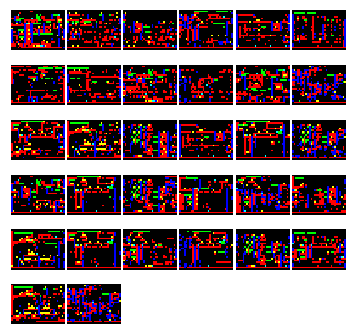

5 th evolution, score_max:0.9001, score_min:0.2536,
[0.78581429 0.2876     0.79462055 0.47629048 0.53256753 0.80861064
 0.31894058 0.74035974 0.75334675 0.55273158 0.9001     0.82904737
 0.67657059 0.8116942  0.47068824 0.53434658 0.51861852 0.82152857
 0.72629048 0.81186471 0.72737273 0.64393562 0.2973973  0.44786119
 0.65394615 0.85724286 0.27037027 0.87961807 0.25362113 0.55415405
 0.83571644 0.62913226]


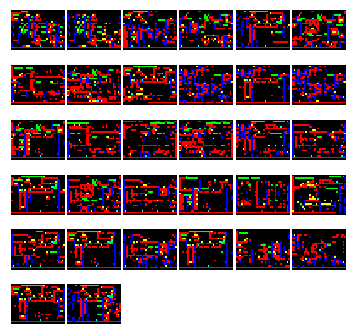

6 th evolution, score_max:0.959, score_min:0.1636,
[0.80962381 0.62172162 0.25520204 0.2376     0.8453381  0.64483684
 0.83833529 0.41473415 0.27282727 0.81186471 0.48581429 0.77282727
 0.16356154 0.54771905 0.51774706 0.79497179 0.8373093  0.84100909
 0.26446782 0.75619756 0.83646364 0.95900411 0.81343333 0.53040303
 0.80831918 0.81091081 0.87961807 0.75394615 0.54661163 0.4557962
 0.65089365 0.61852105]


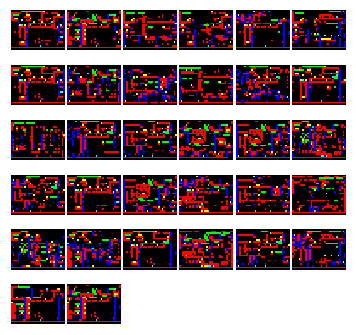

7 th evolution, score_max:0.9242, score_min:0.1689,
[0.86852105 0.7751     0.3201     0.81700141 0.75318642 0.84220526
 0.5251     0.91021236 0.38581429 0.40973855 0.66676667 0.82618696
 0.84941507 0.16893117 0.57657059 0.78581429 0.44937536 0.80565556
 0.81438571 0.6057338  0.52248806 0.52757253 0.70248095 0.73086923
 0.47737273 0.79278293 0.92415063 0.84100909 0.5001     0.44295714
 0.46676667 0.83343333]


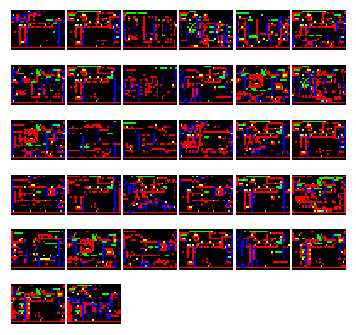

8 th evolution, score_max:0.9635, score_min:0.3627,
[0.52641579 0.82201781 0.37189487 0.44196047 0.5001     0.83554304
 0.73982603 0.87152857 0.78491013 0.60769494 0.81343333 0.8251
 0.72161899 0.515725   0.77951176 0.49360649 0.3944662  0.58343333
 0.6251     0.53856154 0.82964545 0.36273736 0.82618696 0.54295714
 0.38105238 0.49240769 0.8314253  0.82768621 0.96351463 0.78419091
 0.7001     0.85517246]


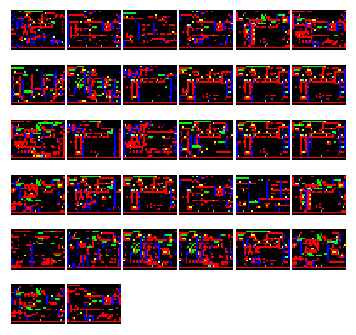

9 th evolution, score_max:0.9168, score_min:0.3583,
[0.79555455 0.5126     0.83126883 0.59766098 0.43293582 0.64393562
 0.59100909 0.6251     0.73144328 0.37847838 0.84755763 0.69746842
 0.82201781 0.74400244 0.86676667 0.76605745 0.48727949 0.91676667
 0.5201     0.35830896 0.84941507 0.49305775 0.42706629 0.54226867
 0.79555455 0.63023699 0.49392716 0.6057338  0.3975359  0.45689012
 0.43033256 0.79462055]


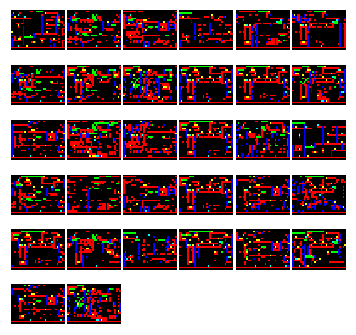

epoch: 0 ,conclusion
raw population


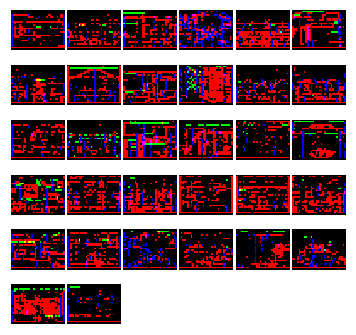

final image


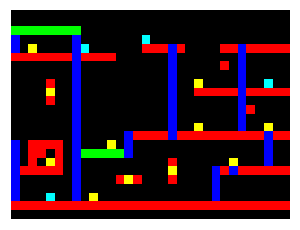

final population


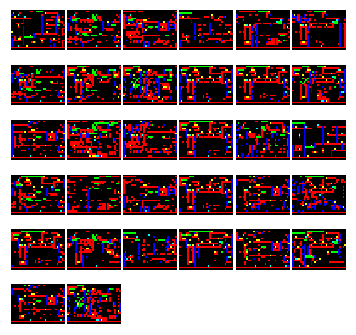

epoch: 1 ,start----------------------------------------------


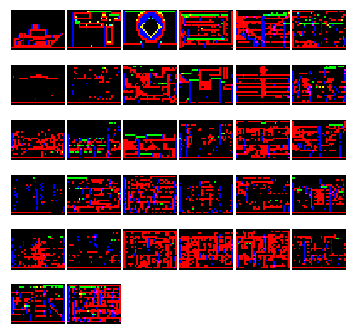

(10000, 24, 32, 5)
0 th evolution, score_max:0.9868, score_min:0.02677,
[0.76633377 0.3751     0.88719677 0.85375854 0.46488873 0.2001
 0.98676667 0.95724286 0.5001     0.2963963  0.23953662 0.75619756
 0.4001     0.58237848 0.89421765 0.19454444 0.6801     0.1001
 0.38382093 0.83086923 0.1026641  0.13934051 0.2501     0.02676667
 0.14676667 0.20557945 0.13590247 0.1370863  0.18431053 0.13167895
 0.04625385 0.04771905]
1 th evolution, score_max:0.9644, score_min:0.06034,
[0.62676667 0.24060633 0.06034096 0.89782727 0.96438571 0.96395542
 0.85565556 0.7805878  0.5953381  0.14094507 0.5001     0.64393562
 0.44881795 0.9201     0.25935926 0.1026641  0.94127647 0.52183913
 0.55233881 0.72849506 0.28388378 0.11852105 0.46676667 0.82099552
 0.37691159 0.47307297 0.63023699 0.64112564 0.29240769 0.45955946
 0.13523514 0.14112564]


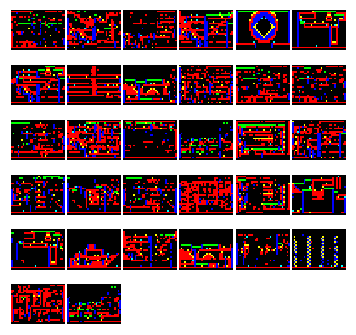

2 th evolution, score_max:0.9864, score_min:0.1409,
[0.54176667 0.64295714 0.15635    0.90287778 0.50547634 0.60820811
 0.88471538 0.91945484 0.51361351 0.49305775 0.48790488 0.734475
 0.28581429 0.43431053 0.61914762 0.79497179 0.57904737 0.48658649
 0.6001     0.98640137 0.51622903 0.41438571 0.15724286 0.82061282
 0.14094507 0.89715882 0.32362941 0.65070241 0.94515495 0.16676667
 0.5001     0.54804521]


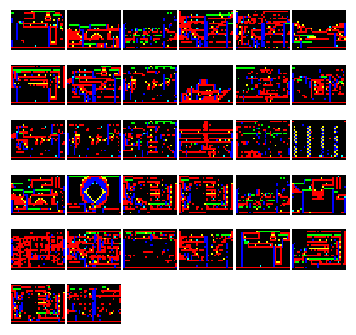

3 th evolution, score_max:0.9553, score_min:0.1843,
[0.6876     0.57327073 0.88321688 0.9048619  0.78092192 0.65527241
 0.70940233 0.50627284 0.4376     0.92217792 0.79462055 0.94881795
 0.37047037 0.18431053 0.95532388 0.80831918 0.61653836 0.53256753
 0.56986744 0.56480588 0.72737273 0.91035641 0.56531739 0.7501
 0.64874865 0.3975359  0.42676667 0.83938571 0.44313797 0.58451558
 0.71651791 0.51588947]


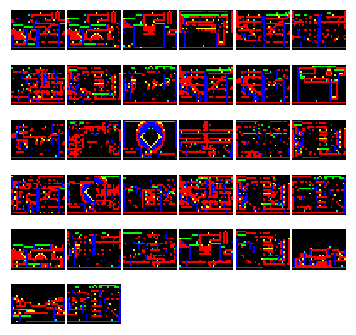

4 th evolution, score_max:0.9866, score_min:0.128,
[0.17152857 0.14593333 0.89782727 0.67577568 0.85925493 0.44295714
 0.47201011 0.81022658 0.57964545 0.64945065 0.98658649 0.71242877
 0.49162542 0.86577164 0.50676667 0.75334675 0.76839268 0.34295714
 0.64295714 0.76398889 0.89020989 0.7501     0.46676667 0.52183913
 0.48694211 0.703225   0.48790488 0.12800698 0.80732892 0.82618696
 0.51525152 0.61121111]


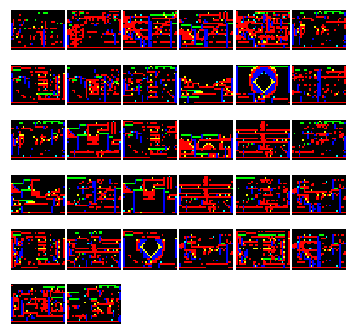

5 th evolution, score_max:0.9507, score_min:0.143,
[0.6801     0.8801     0.95071728 0.28581429 0.53201489 0.48819524
 0.9048619  0.78031978 0.75651026 0.8029169  0.5975026  0.85145135
 0.71062632 0.5001     0.8903439  0.40516329 0.50734638 0.74400244
 0.17920448 0.84295714 0.75394615 0.32152857 0.4495382  0.54771905
 0.55706203 0.69746842 0.5001     0.56636506 0.14295714 0.6801
 0.90919091 0.85517246]


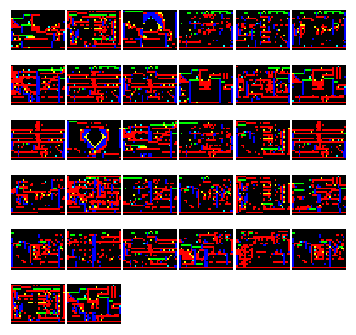

6 th evolution, score_max:0.9507, score_min:0.3289,
[0.93160685 0.58343333 0.76839268 0.7973973  0.78661685 0.8314253
 0.36774706 0.88105238 0.53978254 0.41035641 0.81828182 0.32886712
 0.44196047 0.46163846 0.90676667 0.77037027 0.48111266 0.6001
 0.89051096 0.76325789 0.61343333 0.46488873 0.80831918 0.6126
 0.95071728 0.90779231 0.82618696 0.84732222 0.42115263 0.3876
 0.8029169  0.89665172]


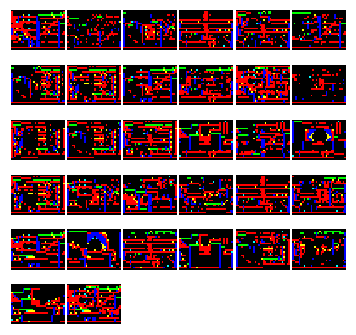

7 th evolution, score_max:0.9711, score_min:0.3254,
[0.82988723 0.84156341 0.73427722 0.3254012  0.66676667 0.92867143
 0.71438571 0.84347349 0.86085949 0.47836087 0.95955946 0.64782727
 0.82032472 0.88167895 0.78957368 0.47629048 0.54804521 0.51200476
 0.68581429 0.9501     0.81343333 0.45464545 0.55415405 0.82061282
 0.97111449 0.81491481 0.67174179 0.73747374 0.65287778 0.82936829
 0.88167895 0.7001    ]


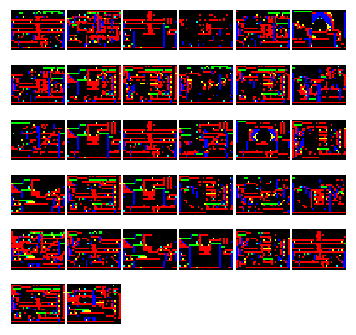

8 th evolution, score_max:0.9232, score_min:0.4226,
[0.59732222 0.76066338 0.7817092  0.71804872 0.75352466 0.65892353
 0.92317692 0.81438571 0.46163846 0.77787778 0.8751     0.42263521
 0.76146364 0.50734638 0.88617595 0.86914762 0.65635    0.59687419
 0.4692358  0.75619756 0.84492759 0.5953381  0.66676667 0.56348028
 0.90799474 0.81588947 0.82936829 0.84625385 0.76096957 0.82152857
 0.9001     0.75651026]


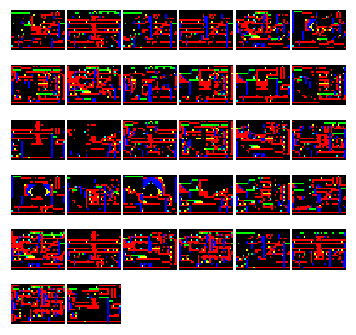

9 th evolution, score_max:0.9771, score_min:0.4139,
[0.66676667 0.68503151 0.76200476 0.78676667 0.77787778 0.8029169
 0.56954444 0.63275306 0.84625385 0.95412299 0.72378421 0.79278293
 0.76398889 0.88774045 0.68125942 0.82549683 0.79421765 0.97711149
 0.8251     0.85403258 0.4138931  0.94815195 0.86852105 0.77976102
 0.7705918  0.49360649 0.58034691 0.91790822 0.72951176 0.86056512
 0.91149241 0.60820811]


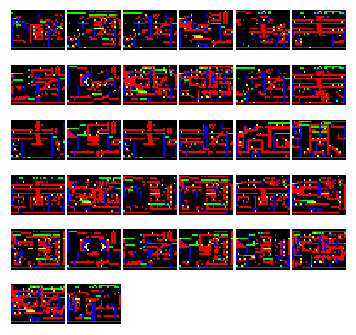

epoch: 1 ,conclusion
raw population


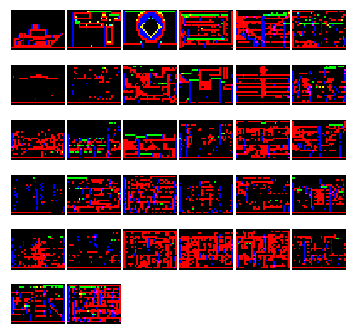

final image


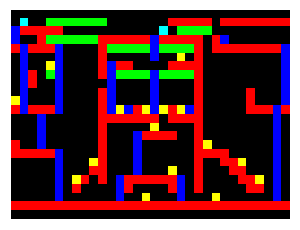

final population


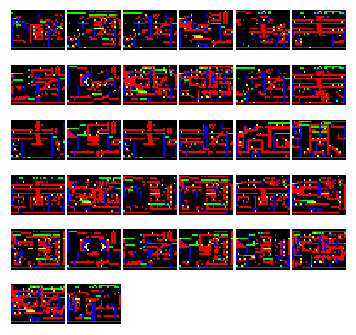

epoch: 2 ,start----------------------------------------------


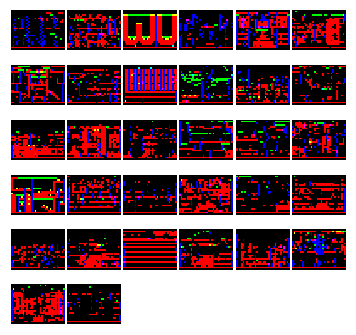

(10000, 24, 32, 5)
0 th evolution, score_max:0.9575, score_min:0.01503,
[0.4251     0.89782727 0.95754681 0.26325789 0.25383134 0.08984359
 0.35304118 0.19777442 0.42475753 0.29483684 0.4626     0.859475
 0.8116942  0.29497179 0.07152857 0.17731519 0.16893117 0.17657059
 0.29518197 0.17343333 0.26480588 0.078225   0.11438571 0.43113448
 0.11504253 0.11914762 0.02676667 0.12369551 0.1251     0.06766757
 0.02867143 0.01502537]
1 th evolution, score_max:0.9196, score_min:0.08229,
[0.91021236 0.31774706 0.27641579 0.25362113 0.25311205 0.77641579
 0.91964023 0.11852105 0.37047037 0.65799474 0.42263521 0.32152857
 0.73873636 0.80779231 0.78833529 0.31717317 0.25767576 0.3903439
 0.2174913  0.17115263 0.32988723 0.43949394 0.18581429 0.1548619
 0.55854156 0.09312326 0.08229178 0.42867143 0.8989764  0.81954444
 0.0953381  0.08705652]


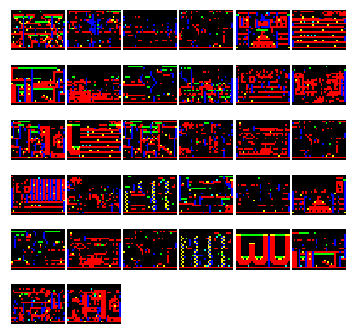

2 th evolution, score_max:0.9707, score_min:0.1668,
[0.19746842 0.8401     0.8001     0.95091967 0.2401     0.6751
 0.24752268 0.95784648 0.72641579 0.453225   0.50694932 0.8001
 0.47955205 0.19057619 0.28581429 0.81977213 0.16676667 0.7376
 0.45464545 0.97068824 0.19057619 0.64798732 0.28925663 0.35536316
 0.26096957 0.73573218 0.91676667 0.3201     0.33343333 0.37152857
 0.26933077 0.34858485]


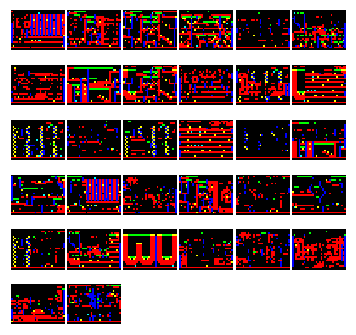

3 th evolution, score_max:0.9532, score_min:0.106,
[0.82676667 0.4048619  0.87152857 0.94604595 0.28368209 0.3374494
 0.36718861 0.89544884 0.71631622 0.10598235 0.92217792 0.77037027
 0.43033256 0.33343333 0.9383716  0.75959367 0.78957368 0.953225
 0.93113448 0.921975   0.17577568 0.3601     0.5943029  0.92483118
 0.17731519 0.80529481 0.13343333 0.31717317 0.29223483 0.26754186
 0.35145135 0.22982973]


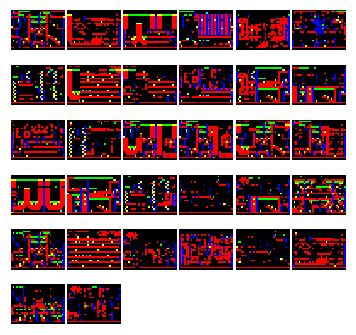

4 th evolution, score_max:0.9849, score_min:0.117,
[0.97193099 0.93680886 0.33776234 0.93431053 0.40550541 0.94212899
 0.88898889 0.87847838 0.29497179 0.98494848 0.8903439  0.83343333
 0.82362941 0.79720145 0.84792609 0.87961807 0.70843333 0.94127647
 0.33812817 0.75619756 0.71438571 0.36718861 0.11698312 0.828225
 0.37672338 0.72423793 0.36852105 0.72378421 0.33343333 0.26875672
 0.18319859 0.69145802]


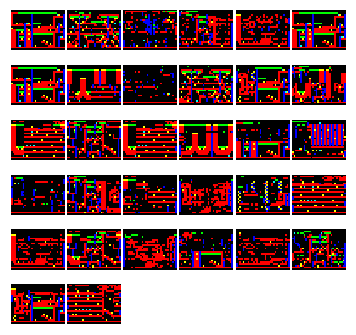

5 th evolution, score_max:0.9757, score_min:0.2411,
[0.72103023 0.71651791 0.9001     0.55082464 0.73343333 0.77787778
 0.58833529 0.86031505 0.82201781 0.93558387 0.91368025 0.7827087
 0.92692927 0.81186471 0.87366322 0.24106386 0.77787778 0.7601
 0.92692927 0.83554304 0.25935926 0.97570976 0.7013987  0.6098561
 0.24667534 0.71196441 0.91576265 0.29518197 0.86756988 0.97111449
 0.29497179 0.8989764 ]


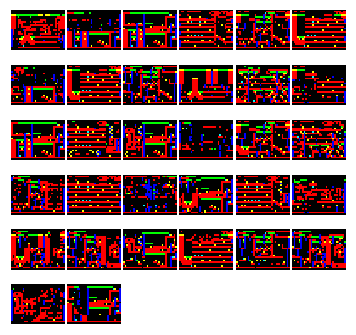

6 th evolution, score_max:0.9635, score_min:0.1359,
[0.77152857 0.78797879 0.13590247 0.8751     0.80962381 0.71438571
 0.56107561 0.76325789 0.7013987  0.59503671 0.20557945 0.85536316
 0.7501     0.93680886 0.88646364 0.29343333 0.9126     0.96163846
 0.67115263 0.87351772 0.80256914 0.3626     0.96351463 0.87664321
 0.20940233 0.9601     0.94881795 0.76480588 0.96306296 0.83343333
 0.48790488 0.8751    ]


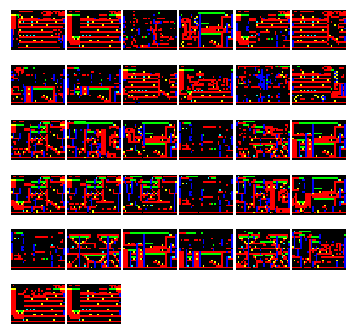

7 th evolution, score_max:0.976, score_min:0.1478,
[0.94196047 0.69454444 0.9048619  0.5201     0.67911235 0.96521628
 0.73043708 0.90287778 0.90253902 0.97600361 0.86676667 0.93253243
 0.95754681 0.9501     0.68827204 0.90598235 0.65227391 0.93343333
 0.83793784 0.84220526 0.75959367 0.6801     0.77916977 0.7501
 0.35453038 0.2968033  0.7876     0.14782727 0.5751     0.95190723
 0.82288481 0.94328182]


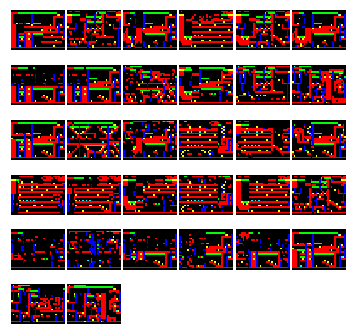

8 th evolution, score_max:0.9745, score_min:0.05566,
[0.86085949 0.90919091 0.8001     0.84220526 0.90779231 0.81022658
 0.6876     0.83086923 0.88382093 0.05565556 0.8975359  0.6780661
 0.74127647 0.77787778 0.94212899 0.29278293 0.75278817 0.70432535
 0.9601     0.69127647 0.91676667 0.93912439 0.89343333 0.97445897
 0.96062632 0.7501     0.96062632 0.78388378 0.8962039  0.79797234
 0.4401     0.81022658]


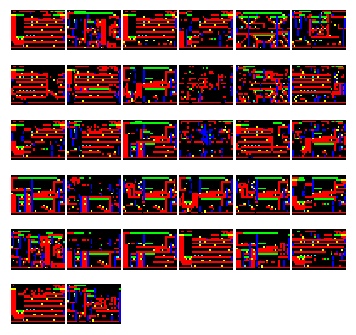

9 th evolution, score_max:0.9488, score_min:0.1766,
[0.82964545 0.86548462 0.72161899 0.7501     0.83554304 0.69024085
 0.92867143 0.86774706 0.91368025 0.80655161 0.84425584 0.84454444
 0.70248095 0.83539412 0.94881795 0.17657059 0.9048619  0.87333944
 0.92657059 0.8903439  0.91035641 0.92317692 0.47836087 0.94328182
 0.69454444 0.73343333 0.7126     0.86966522 0.39715882 0.94746842
 0.74252424 0.8376    ]


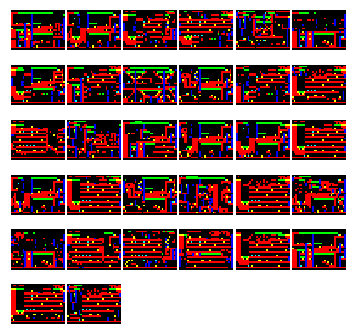

epoch: 2 ,conclusion
raw population


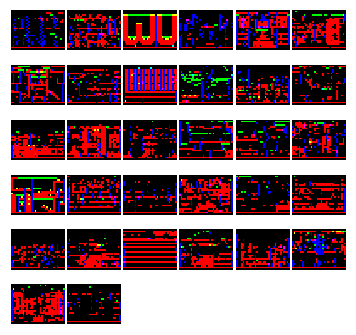

final image


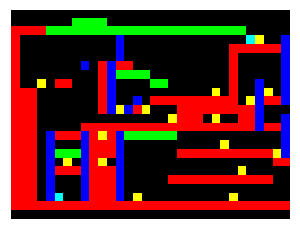

final population


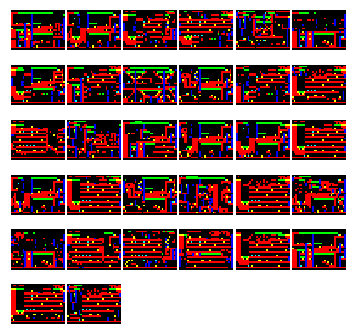

epoch: 3 ,start----------------------------------------------


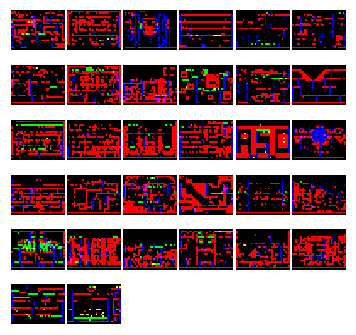

(10000, 24, 32, 5)
0 th evolution, score_max:0.9557, score_min:0.0001,
[3.78478378e-01 9.55655556e-01 2.88759794e-01 5.50661798e-01
 3.90610390e-02 5.15251515e-01 7.18409859e-01 7.42957143e-01
 9.25100000e-01 9.04209589e-01 2.10626316e-01 2.70688235e-01
 5.07142254e-01 2.14385714e-01 3.21939080e-01 7.83883784e-01
 2.11367606e-01 1.06160606e-01 2.02631646e-01 3.02731579e-01
 9.10090909e-02 2.37600000e-01 2.30885057e-02 7.23891566e-02
 1.90576190e-01 1.11211111e-01 2.02802703e-01 2.71270270e-02
 6.16384615e-02 1.48058824e-02 1.72939506e-01 1.00000000e-04]
1 th evolution, score_max:0.9788, score_min:0.07417,
[0.50694932 0.8751     0.60724286 0.23890597 0.72867143 0.07964545
 0.6742573  0.22378421 0.7973973  0.22545211 0.31954444 0.3453381
 0.46885    0.43671972 0.38971039 0.62328841 0.34220526 0.13167895
 0.2248191  0.328225   0.07417407 0.5001     0.19763086 0.40635
 0.4001     0.22232222 0.18065556 0.19057619 0.49360649 0.17958718
 0.9788234  0.47955205]


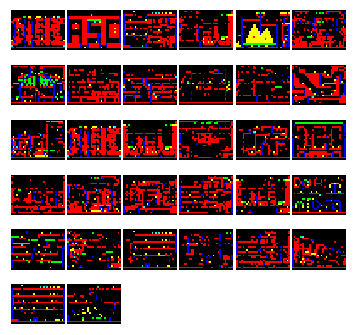

2 th evolution, score_max:0.9541, score_min:0.1221,
[0.19522195 0.16480588 0.5751     0.30565556 0.54064054 0.30273158
 0.17958718 0.95412299 0.26754186 0.18928919 0.77037027 0.38971039
 0.5001     0.60616061 0.19522195 0.31828182 0.78491013 0.28215128
 0.91149241 0.28745632 0.31676667 0.17115263 0.9001     0.32404366
 0.34256575 0.66325789 0.12205122 0.30389747 0.45248095 0.46401753
 0.54555455 0.38581429]


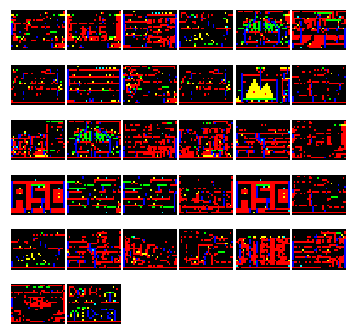

3 th evolution, score_max:0.9874, score_min:0.07605,
[0.36595366 0.95358837 0.66676667 0.07604937 0.38551667 0.90919091
 0.6026641  0.28995507 0.4001     0.4026974  0.2801     0.3944662
 0.33833529 0.5126     0.3876     0.79079767 0.36496486 0.93253243
 0.58218955 0.86852105 0.44746842 0.69873014 0.98744177 0.76398889
 0.70159254 0.80892353 0.50642911 0.38581429 0.39199189 0.18302683
 0.31516849 0.13167895]


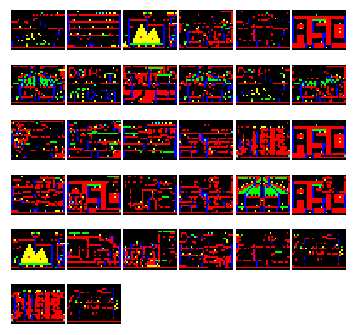

4 th evolution, score_max:1.0, score_min:0.03185,
[0.82726049 0.171975   0.57343333 0.34949759 0.65681642 1.0001
 0.72378421 0.77037027 0.30676667 0.52867143 0.35145135 0.91314348
 0.51908734 0.8001     0.03184603 0.22103023 0.59220526 0.70432535
 0.22087922 0.36595366 0.85517246 0.41583034 0.93516494 0.92217792
 0.24685325 0.33776234 0.7876     0.34732222 0.20418163 0.82549683
 0.4110589  0.8975359 ]


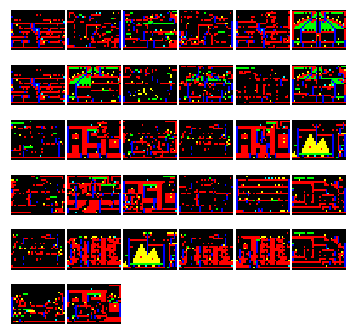

5 th evolution, score_max:1.0, score_min:0.1715,
[0.92415063 0.29497179 0.37691159 0.26480588 0.95900411 0.33343333
 0.17152857 0.18928919 0.84156341 0.92602593 0.64483684 0.30962381
 0.93343333 0.36373636 0.86496486 0.66186471 0.97711149 0.859475
 0.84546082 0.17867143 1.0001     0.82288481 0.4026974  0.44786119
 0.48790488 0.4138931  0.4026974  0.41801045 0.37152857 0.76281186
 0.68302683 0.72951176]


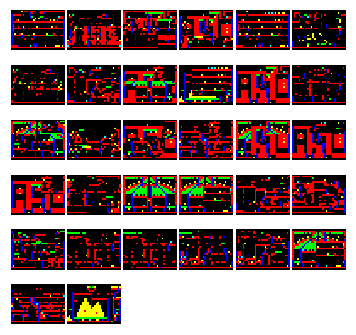

6 th evolution, score_max:1.0, score_min:0.2074,
[0.31044483 0.64874865 0.44328182 0.86914762 1.0001     0.40799474
 0.83571644 0.72161899 0.98676667 0.9251     0.73923043 0.78957368
 0.71094337 0.71024493 0.7655321  0.20741707 0.37047037 0.81717317
 0.91676667 1.0001     0.42115263 0.31121111 0.2988013  0.39516173
 0.94392022 0.41782152 0.2751     0.72629048 0.88321688 0.42434242
 0.98727949 0.73265814]


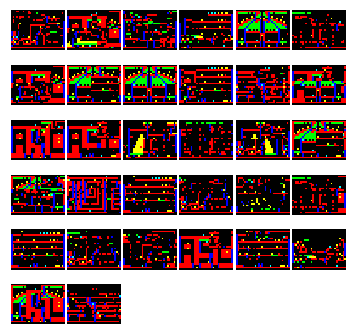

7 th evolution, score_max:1.0, score_min:0.2688,
[0.32921392 0.77368491 0.92434242 1.0001     0.35724286 0.44196047
 0.77787778 0.72378421 0.78581429 0.9876     0.65178539 0.70896076
 0.30655161 0.75767576 1.0001     0.31353284 0.88898889 0.4940759
 0.7601     0.78419091 0.98560725 0.85343333 0.80711754 0.28405062
 0.88898889 0.84732222 0.75767576 0.26875672 0.34893721 0.78883239
 0.59100909 0.8022978 ]


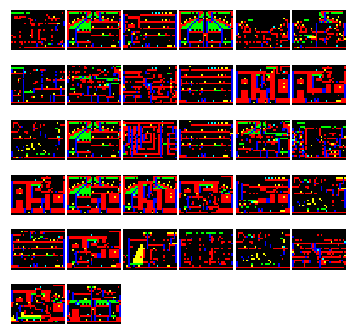

8 th evolution, score_max:1.0, score_min:0.1409,
[0.80831918 0.33793784 0.97445897 0.89403939 0.66226216 0.79114478
 0.23386623 0.98775432 0.74722644 0.81977213 0.38676667 1.0001
 0.79230779 0.79462055 0.14094507 0.43431053 0.44313797 0.22378421
 0.72317692 0.33793784 0.84347349 0.41945484 0.75913614 0.85724286
 0.7001     0.82549683 0.63390282 0.72299157 1.0001     0.3251
 1.0001     0.79176667]


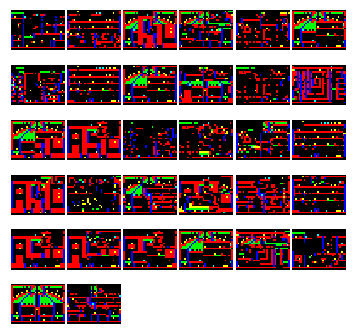

9 th evolution, score_max:1.0, score_min:0.4025,
[0.62172162 0.97684419 0.40253902 0.87814878 0.66676667 0.95532388
 0.88167895 0.7001     0.85145135 0.6801     0.55138205 0.7028027
 0.83848384 0.45358837 0.48727949 0.43253243 0.65394615 0.76200476
 0.79771905 1.0001     0.58676667 0.74636866 0.85907436 1.0001
 0.80655161 0.98658649 0.72849506 0.50659351 0.97378421 0.88105238
 0.85724286 0.68125942]


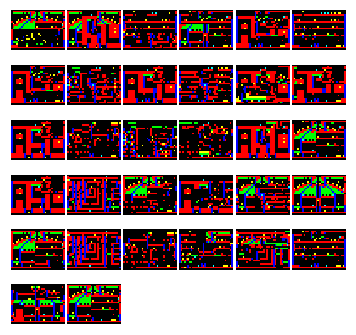

epoch: 3 ,conclusion
raw population


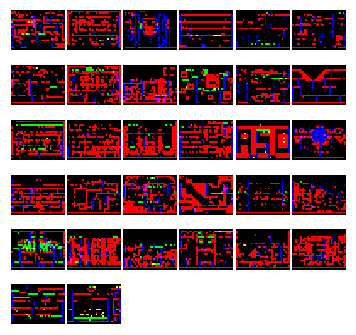

final image


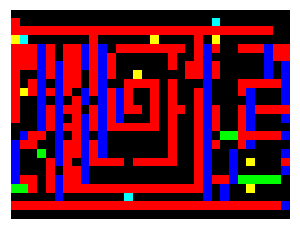

final population


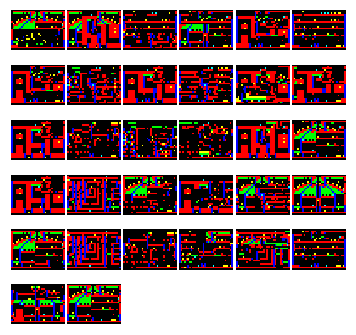

epoch: 4 ,start----------------------------------------------


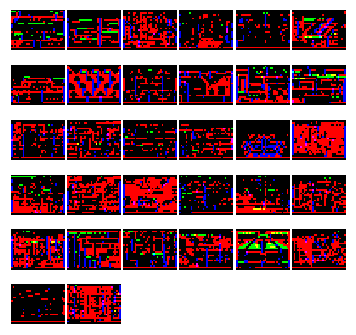

(10000, 24, 32, 5)
0 th evolution, score_max:0.9156, score_min:0.06907,
[0.33343333 0.33343333 0.87189487 0.90150845 0.24060633 0.47737273
 0.38245294 0.31405349 0.42263521 0.39250506 0.51325789 0.40550541
 0.17657059 0.15394615 0.12997013 0.91559296 0.48111266 0.22350426
 0.73923043 0.85724286 0.64715882 0.23953662 0.43219877 0.49343333
 0.21136761 0.24060633 0.06906552 0.17657059 0.0751     0.08651975
 0.12951176 0.07256377]
1 th evolution, score_max:0.9185, score_min:0.04888,
[0.49263731 0.52951176 0.31044483 0.53022048 0.91846735 0.32951176
 0.3903439  0.86756988 0.64295714 0.29587465 0.40516329 0.64715882
 0.77474789 0.57152857 0.21804872 0.2801     0.05489452 0.55304118
 0.51325789 0.35074935 0.15078493 0.1001     0.40550541 0.12058193
 0.34893721 0.40635    0.89483684 0.04888049 0.13590247 0.54676667
 0.87681233 0.44604595]


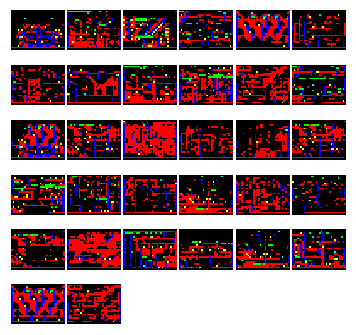

2 th evolution, score_max:0.9688, score_min:0.1225,
[0.23621111 0.13167895 0.93343333 0.36774706 0.54064054 0.54676667
 0.28581429 0.57618696 0.92967746 0.12254898 0.13343333 0.96885
 0.6057338  0.25343333 0.27720843 0.68841169 0.43431053 0.24625385
 0.83343333 0.35907436 0.33793784 0.6001     0.35626438 0.2827087
 0.38564217 0.36996301 0.41945484 0.71438571 0.5001     0.54295714
 0.42115263 0.24060633]


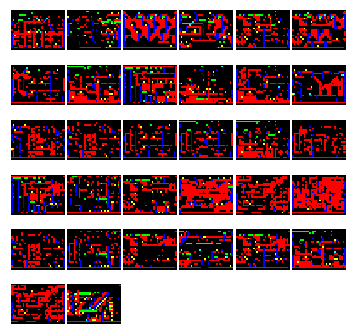

3 th evolution, score_max:0.9295, score_min:0.1501,
[0.22737273 0.80337869 0.40459438 0.35812469 0.35394615 0.53531127
 0.7722519  0.71024493 0.54804521 0.17592418 0.71062632 0.62205122
 0.70124943 0.15724286 0.43599744 0.34256575 0.20522821 0.62676667
 0.56954444 0.75334675 0.86595366 0.1501     0.51398889 0.92951176
 0.1548619  0.21927808 0.45843333 0.42038986 0.1876     0.51325789
 0.2501     0.23386623]


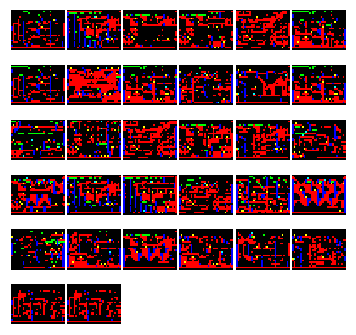

4 th evolution, score_max:0.9376, score_min:0.1979,
[0.33343333 0.80962381 0.60616061 0.45955946 0.84517042 0.57456809
 0.37219302 0.63301139 0.9376     0.23621111 0.5953381  0.77932078
 0.90826327 0.28368209 0.56588947 0.73249437 0.43047975 0.2968033
 0.49448202 0.86450678 0.39769036 0.7261274  0.66676667 0.65681642
 0.24685325 0.60283973 0.35145135 0.73694211 0.67787778 0.1979022
 0.44937536 0.88742394]


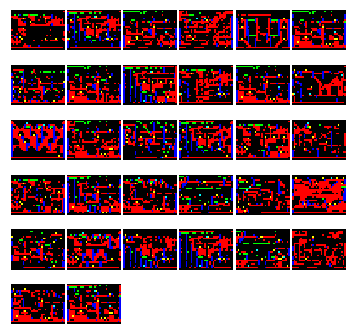

5 th evolution, score_max:0.9001, score_min:0.1936,
[0.69343333 0.87333944 0.3001     0.41676667 0.4376     0.66676667
 0.78581429 0.2174913  0.5876     0.19364839 0.57343333 0.55304118
 0.4251     0.49377089 0.36852105 0.4376     0.5001     0.24647681
 0.60475116 0.71631622 0.72982973 0.9001     0.78661685 0.87814878
 0.27858101 0.5891411  0.85145135 0.37047037 0.87888788 0.5953381
 0.58581429 0.45273158]


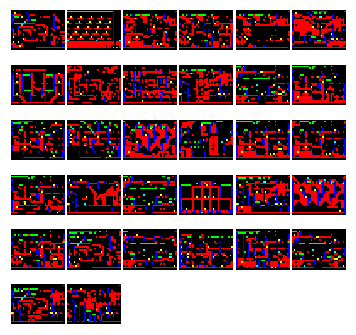

6 th evolution, score_max:0.8988, score_min:0.03957,
[0.3975359  0.8029169  0.3601     0.83086923 0.86966522 0.86774706
 0.64945065 0.7973973  0.48581429 0.29278293 0.56070606 0.75318642
 0.3126     0.5001     0.83343333 0.24478085 0.03957368 0.3751
 0.44604595 0.81491481 0.59560562 0.89883418 0.35304118 0.84156341
 0.75913614 0.58581429 0.2740726  0.54421765 0.66676667 0.34792609
 0.765725   0.87847838]


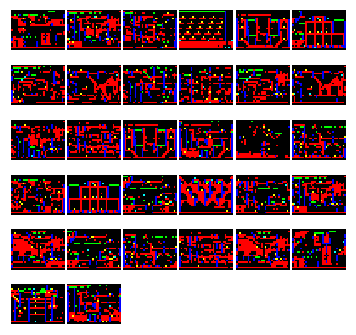

7 th evolution, score_max:0.9685, score_min:0.2652,
[0.81717317 0.86914762 0.63390282 0.76676667 0.71242877 0.84385
 0.90676667 0.91790822 0.56766757 0.81977213 0.78491013 0.36373636
 0.63865422 0.85724286 0.82201781 0.37047037 0.7876     0.26516024
 0.83960617 0.59503671 0.82152857 0.32362941 0.640725   0.35074935
 0.74400244 0.84732222 0.84454444 0.75394615 0.83108592 0.47262747
 0.96852105 0.72629048]


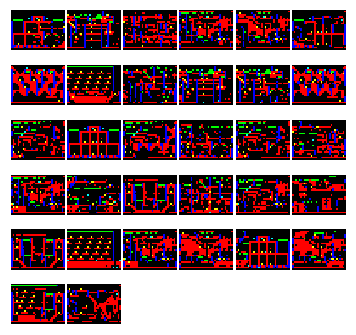

8 th evolution, score_max:0.9507, score_min:0.2964,
[0.77429355 0.94454444 0.95071728 0.81828182 0.56828182 0.2963963
 0.38581429 0.3254012  0.77787778 0.82676667 0.609475   0.45955946
 0.62172162 0.35965056 0.84893721 0.82427582 0.88581429 0.89562239
 0.6120403  0.76933077 0.5001     0.53957368 0.88617595 0.7001
 0.86548462 0.78698525 0.7038037  0.62131212 0.94676667 0.8029169
 0.7376     0.34295714]


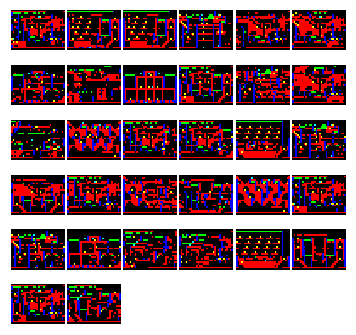

9 th evolution, score_max:0.9278, score_min:0.2661,
[0.80831918 0.55273158 0.92781084 0.921975   0.85724286 0.47955205
 0.89240769 0.57544247 0.40550541 0.85925493 0.85237273 0.90550541
 0.76325789 0.51622903 0.81937711 0.6628907  0.4251     0.47378421
 0.91676667 0.91945484 0.34256575 0.91186471 0.91790822 0.45064945
 0.65394615 0.32108765 0.86373636 0.42867143 0.6548619  0.26605745
 0.87814878 0.8801    ]


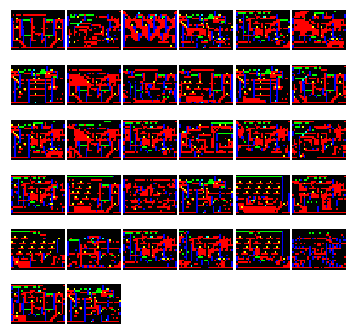

epoch: 4 ,conclusion
raw population


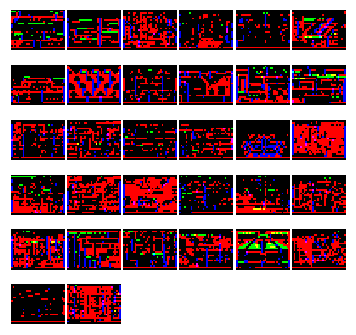

final image


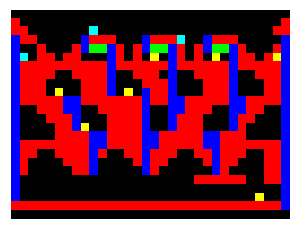

final population


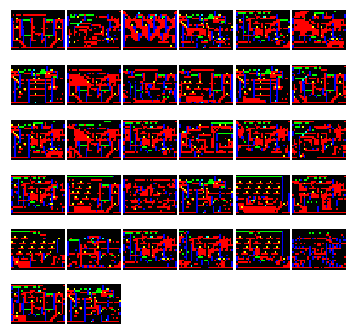

epoch: 5 ,start----------------------------------------------


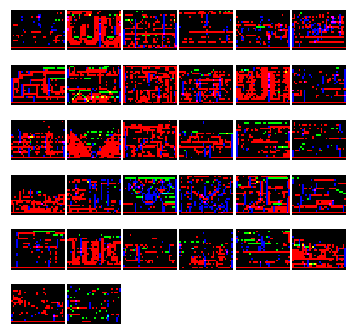

(10000, 24, 32, 5)
0 th evolution, score_max:0.8096, score_min:0.02642,
[0.26051667 0.57787778 0.30779231 0.19490519 0.61653836 0.5126
 0.21438571 0.2001     0.19188082 0.33343333 0.19454444 0.30676667
 0.27282727 0.29176667 0.80962381 0.2988013  0.14952529 0.19328182
 0.4048619  0.32152857 0.33793784 0.27282727 0.24295714 0.37691159
 0.17818219 0.02641579 0.3126     0.10968904 0.05273158 0.15161515
 0.14295714 0.05138205]
1 th evolution, score_max:0.8452, score_min:0.05566,
[0.84517042 0.23953662 0.83880968 0.11637907 0.3453381  0.48658649
 0.20843333 0.23819524 0.21631622 0.29497179 0.30444783 0.63167895
 0.21515376 0.08343333 0.51325789 0.28581429 0.2346679  0.07378421
 0.38212247 0.05565556 0.17787778 0.11121111 0.52951176 0.37189487
 0.14676667 0.76821594 0.11121111 0.2346679  0.3001     0.3201
 0.37047037 0.24667534]


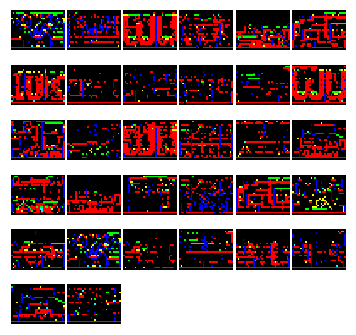

2 th evolution, score_max:0.8781, score_min:0.08343,
[0.87814878 0.54555455 0.59659123 0.38343333 0.26976292 0.26037397
 0.0863069  0.25343333 0.20789221 0.81954444 0.44165844 0.83343333
 0.64483684 0.45215479 0.25362113 0.48694211 0.30130482 0.2196122
 0.13245294 0.08343333 0.2988013  0.38382093 0.15304118 0.32921392
 0.30389747 0.64140435 0.73819524 0.5001     0.20889121 0.23343333
 0.45955946 0.2805878 ]


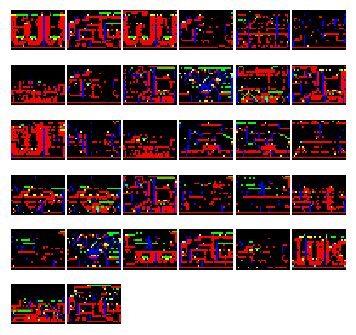

3 th evolution, score_max:0.8554, score_min:0.1128,
[0.12997013 0.23265814 0.8126     0.30691818 0.23386623 0.44786119
 0.70598235 0.56348028 0.12668228 0.84546082 0.29421765 0.32904737
 0.85536316 0.15883016 0.36996301 0.77787778 0.41945484 0.6251
 0.41438571 0.61738395 0.54330988 0.35221268 0.37941034 0.24667534
 0.11277606 0.2740726  0.41801045 0.20522821 0.29421765 0.55415405
 0.49377089 0.17731519]


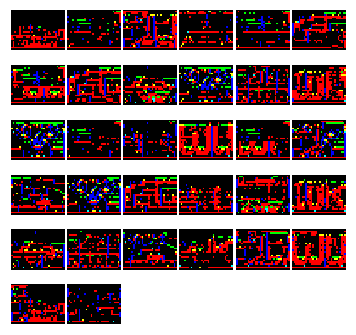

4 th evolution, score_max:0.9131, score_min:0.1015,
[0.66676667 0.68302683 0.64874865 0.55923978 0.71840986 0.78092192
 0.20977742 0.47702308 0.82676667 0.32867143 0.1370863  0.39250506
 0.2001     0.4085507  0.10154928 0.3501     0.29343333 0.3944662
 0.4517129  0.26875672 0.91314348 0.80831918 0.49305775 0.7973973
 0.82061282 0.22867143 0.2601     0.19490519 0.63523514 0.1972831
 0.5001     0.52552373]


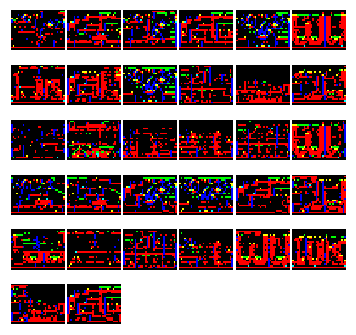

5 th evolution, score_max:0.8948, score_min:0.09343,
[0.78581429 0.61676667 0.28179014 0.37691159 0.52951176 0.40993607
 0.34492759 0.65161515 0.34156341 0.78215128 0.6057338  0.54176667
 0.6126     0.46351463 0.75372319 0.47787778 0.78491013 0.17470317
 0.65919091 0.37984684 0.69127647 0.59149785 0.21222121 0.89483684
 0.25591395 0.78471538 0.09343333 0.47445897 0.4058971  0.20248095
 0.67615634 0.4001    ]


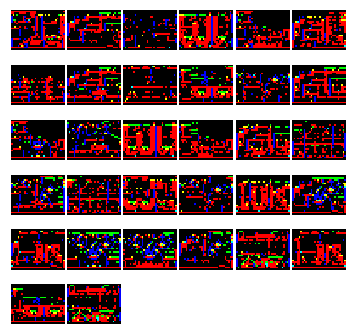

6 th evolution, score_max:0.9519, score_min:0.2704,
[0.640725   0.87681233 0.35626438 0.84625385 0.60879565 0.95190723
 0.27720843 0.55691818 0.43113448 0.53040303 0.6626     0.41568442
 0.56954444 0.49305775 0.91473415 0.6836443  0.77657059 0.28581429
 0.42263521 0.6401     0.2963963  0.52282727 0.58034691 0.27037027
 0.39715882 0.56726418 0.55892353 0.27787778 0.73503976 0.77787778
 0.74167303 0.58118108]


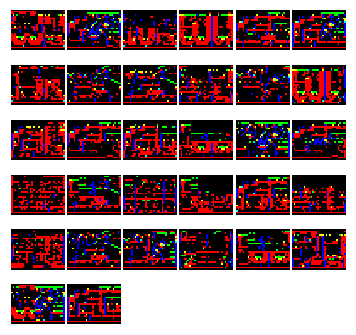

7 th evolution, score_max:0.9232, score_min:0.224,
[0.7038037  0.8626     0.28581429 0.82867143 0.65343333 0.88898889
 0.51525152 0.76633377 0.7762194  0.74613175 0.67542468 0.41676667
 0.44454444 0.41782152 0.70741707 0.29860746 0.74400244 0.47307297
 0.92317692 0.55415405 0.2239806  0.86595366 0.34949759 0.24334324
 0.7722519  0.40799474 0.63539412 0.6251     0.29223483 0.44313797
 0.63502063 0.60724286]


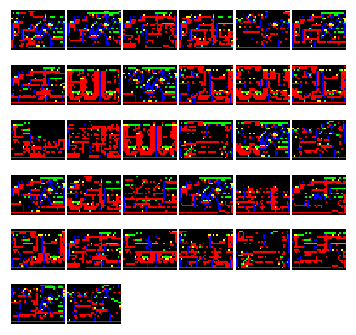

8 th evolution, score_max:0.9049, score_min:0.2223,
[0.53957368 0.51361351 0.75959367 0.50584713 0.5943029  0.87189487
 0.58581429 0.4001     0.32936829 0.78388378 0.82676667 0.6001
 0.3254012  0.78581429 0.85907436 0.53618247 0.76200476 0.90420959
 0.52469016 0.23386623 0.9048619  0.53531127 0.67542468 0.87366322
 0.63523514 0.46676667 0.7251     0.56933077 0.640725   0.35221268
 0.24400244 0.22232222]


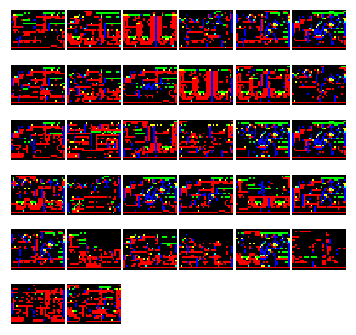

9 th evolution, score_max:0.9711, score_min:0.1411,
[0.97111449 0.76398889 0.77037027 0.78215128 0.57544247 0.8962039
 0.14112564 0.74636866 0.46763247 0.40332581 0.42867143 0.47232222
 0.51861852 0.92144831 0.54555455 0.54888049 0.51361351 0.296975
 0.52787778 0.51229512 0.80691818 0.5975026  0.65763425 0.828225
 0.65343333 0.74295714 0.94196047 0.72299157 0.9048619  0.91035641
 0.16893117 0.90635   ]


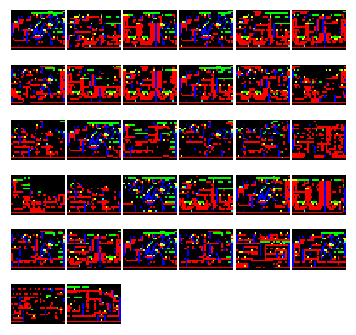

epoch: 5 ,conclusion
raw population


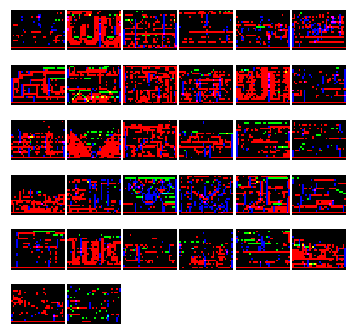

final image


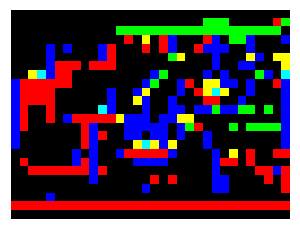

final population


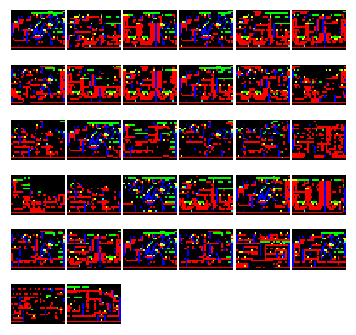

epoch: 6 ,start----------------------------------------------


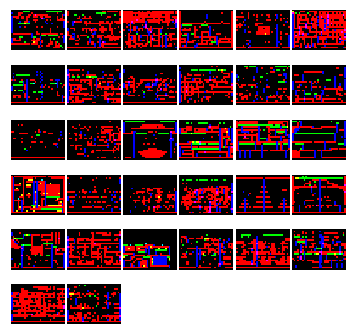

(10000, 24, 32, 5)
0 th evolution, score_max:0.9693, score_min:0.0001,
[2.24819101e-01 3.42205263e-01 8.60315054e-01 6.11211111e-01
 7.69330769e-01 2.00100000e-01 9.16766667e-01 8.10910811e-01
 2.77877778e-01 4.11058904e-01 7.61294030e-01 6.23629412e-01
 9.52480952e-01 9.69330769e-01 1.35902469e-01 8.31425301e-01
 6.94217647e-01 5.11727907e-01 6.26000000e-02 1.11211111e-01
 6.03041176e-01 5.27315789e-02 2.71704938e-01 2.96975000e-01
 1.66766667e-01 1.48248148e-01 7.05225352e-02 8.54658537e-02
 6.58894737e-02 5.01000000e-02 2.41963855e-02 1.00000000e-04]
1 th evolution, score_max:0.9763, score_min:0.03498,
[0.23539412 0.80607015 0.90332581 0.2876     0.85343333 0.04948272
 0.24400244 0.2988013  0.10136582 0.60769494 0.90919091 0.2501
 0.73873636 0.97629048 0.68263968 0.85724286 0.30565556 0.86595366
 0.57904737 0.1687747  0.51958052 0.0876     0.6751     0.17343333
 0.55394615 0.39199189 0.95724286 0.68841169 0.42263521 0.97152857
 0.22676667 0.03498372]


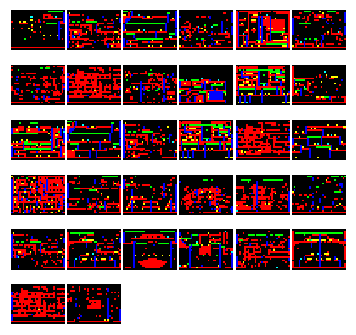

2 th evolution, score_max:1.0, score_min:0.0401,
[0.91559296 0.47068824 0.81022658 0.890725   0.8751     0.9001
 0.13803103 1.0001     0.78883239 0.22103023 0.5001     0.94454444
 0.77343333 0.86031505 0.0401     0.74127647 0.82867143 0.5501
 0.26676667 0.34676667 0.61981831 0.5916493  0.20248095 0.46979697
 0.1628907  0.90371446 0.08984359 0.79320345 0.12775957 0.3751
 0.71631622 0.28135   ]


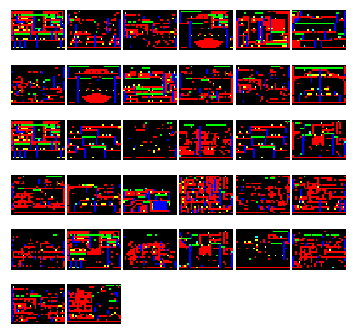

3 th evolution, score_max:0.9763, score_min:0.06954,
[0.90150845 0.51556392 0.89865072 0.83571644 0.41568442 0.48727949
 0.24368974 0.48397097 0.26325789 0.74693544 0.40308507 0.92781084
 0.9201     0.22378421 0.6501     0.91438571 0.57152857 0.42115263
 0.78581429 0.91790822 0.07417407 0.68343333 0.44057619 0.56531739
 0.7501     0.68614651 0.58833529 0.88245294 0.8876     0.06954444
 0.4501     0.97629048]


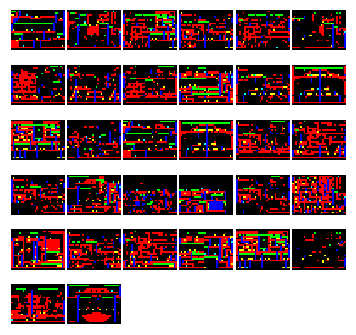

4 th evolution, score_max:0.9482, score_min:0.1832,
[0.57904737 0.20464545 0.81438571 0.8975359  0.88742394 0.28179014
 0.9376     0.48727949 0.44937536 0.90332581 0.28797879 0.28388378
 0.36629718 0.26976292 0.47484747 0.93985904 0.91186471 0.7876
 0.9001     0.44881795 0.90707674 0.18319859 0.33343333 0.93343333
 0.71024493 0.73343333 0.94815195 0.52183913 0.86496486 0.34930635
 0.29421765 0.62972963]


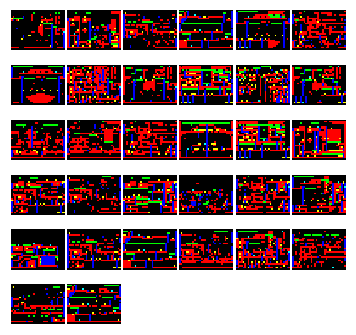

5 th evolution, score_max:1.0, score_min:0.2562,
[0.5601     0.75352466 0.25619756 1.0001     0.91473415 0.90253902
 0.32951176 0.80497805 0.73265814 0.9251     0.9251     0.27037027
 0.47445897 0.97024925 0.33343333 0.67083171 0.8876     0.57841325
 0.86966522 0.7001     0.92967746 0.41782152 0.72951176 0.921975
 0.85892353 0.50659351 0.87219302 0.43688161 0.55415405 0.65892353
 0.52712703 0.59312326]


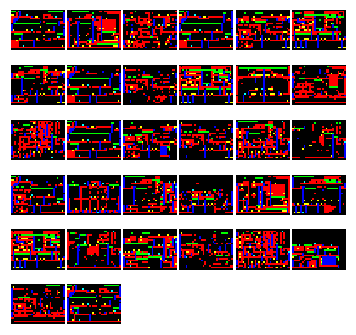

6 th evolution, score_max:0.9439, score_min:0.2144,
[0.8903439  0.49360649 0.49240769 0.21438571 0.64112564 0.7827087
 0.91901892 0.94392022 0.90635    0.78581429 0.9048619  0.80892353
 0.94295714 0.69873014 0.77152857 0.74428605 0.84347349 0.90598235
 0.51361351 0.88382093 0.60237273 0.87961807 0.54064054 0.87152857
 0.73503976 0.91762577 0.78092192 0.90287778 0.43431053 0.57637119
 0.86676667 0.71274368]


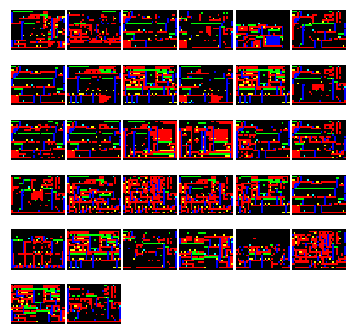

7 th evolution, score_max:0.9596, score_min:0.07363,
[0.95955946 0.88898889 0.50642911 0.4251     0.6120403  0.85084627
 0.78883239 0.9126     0.88415797 0.92867143 0.89483684 0.87961807
 0.70843333 0.88898889 0.87664321 0.67251379 0.88898889 0.81954444
 0.69630253 0.52390952 0.93253243 0.66676667 0.37219302 0.87787778
 0.92434242 0.5001     0.07362941 0.78343333 0.88321688 0.66676667
 0.86373636 0.6098561 ]


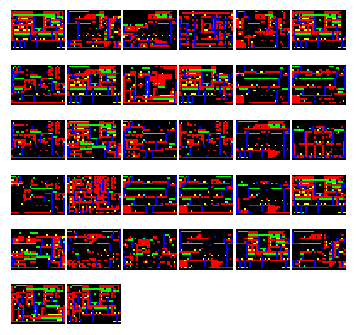

8 th evolution, score_max:0.9584, score_min:0.3937,
[0.8962039  0.62830513 0.9001     0.69127647 0.56986744 0.93065556
 0.8376     0.83539412 0.43558387 0.56070606 0.91473415 0.88742394
 0.66207183 0.87351772 0.8751     0.90332581 0.95464545 0.68614651
 0.87351772 0.6001     0.89199189 0.39371702 0.84715882 0.95724286
 0.84858485 0.62035316 0.7753809  0.5061241  0.95843333 0.43033256
 0.49377089 0.84517042]


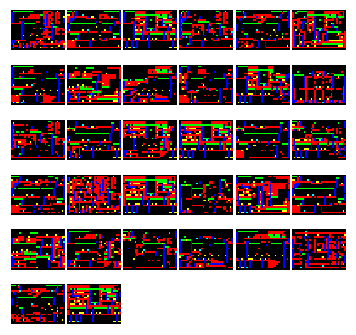

9 th evolution, score_max:0.9488, score_min:0.1269,
[0.93627021 0.90287778 0.62972963 0.88471538 0.12686056 0.34256575
 0.36216897 0.81438571 0.94881795 0.91473415 0.84100909 0.91901892
 0.91035641 0.42706629 0.7876     0.92115263 0.44454444 0.43047975
 0.48539412 0.87888788 0.53856154 0.5001     0.83156067 0.8501
 0.26325789 0.90919091 0.93431053 0.8876     0.78388378 0.92217792
 0.8001     0.86595366]


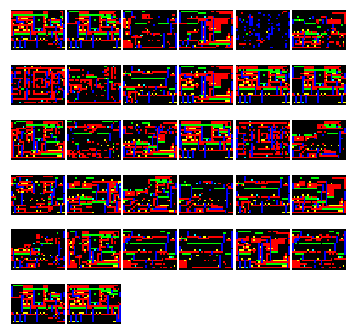

epoch: 6 ,conclusion
raw population


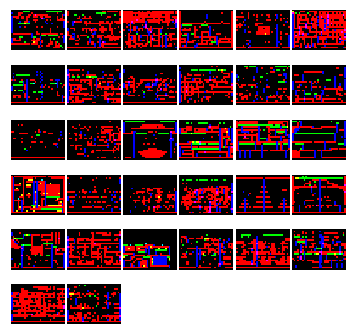

final image


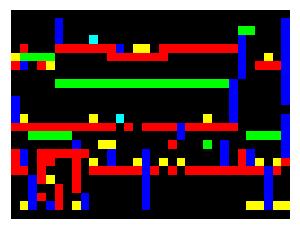

final population


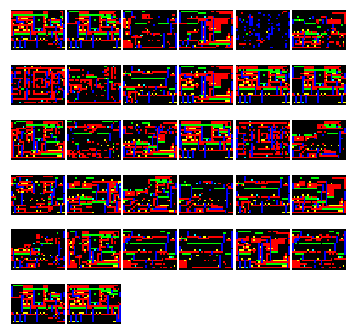

epoch: 7 ,start----------------------------------------------


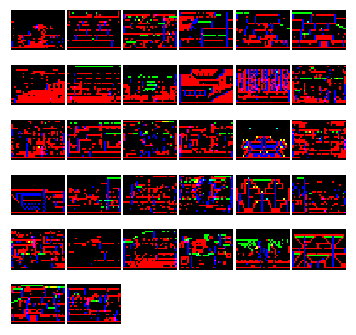

(10000, 24, 32, 5)
0 th evolution, score_max:0.9611, score_min:0.01134,
[0.96113896 0.80565556 0.71242877 0.83343333 0.52064795 0.3256814
 0.51817229 0.31335301 0.94376197 0.86756988 0.84625385 0.17055455
 0.70977742 0.26592278 0.47068824 0.63523514 0.61852105 0.06461613
 0.95955946 0.1972831  0.17293951 0.14094507 0.56420256 0.18928919
 0.6401     0.30598235 0.30130482 0.06392979 0.16893117 0.0626
 0.1251     0.01133596]
1 th evolution, score_max:0.9702, score_min:0.1501,
[0.97024925 0.89051096 0.96062632 0.43065556 0.64644146 0.56331839
 0.87022987 0.19188082 0.58581429 0.88898889 0.7126     0.3975359
 0.8903439  0.28581429 0.44454444 0.85237273 0.29343333 0.18614651
 0.25767576 0.26839268 0.96676667 0.89483684 0.8626     0.18065556
 0.87888788 0.74167303 0.15635    0.42115263 0.1501     0.27858101
 0.19454444 0.20741707]


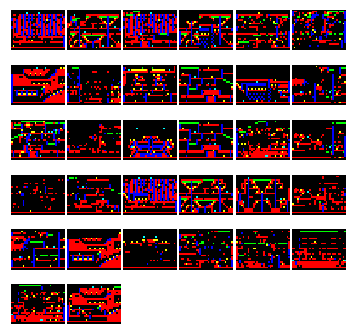

2 th evolution, score_max:0.9766, score_min:0.1971,
[0.93253243 0.76722329 0.76325789 0.20741707 0.5001     0.96212532
 0.90420959 0.29771905 0.23953662 0.94262874 0.2988013  0.44165844
 0.52335581 0.86577164 0.25724286 0.28405062 0.33343333 0.9126
 0.87022987 0.28581429 0.83554304 0.80831918 0.63746264 0.96561724
 0.7805878  0.97657059 0.1970697  0.93113448 0.82362941 0.82676667
 0.88471538 0.48494848]


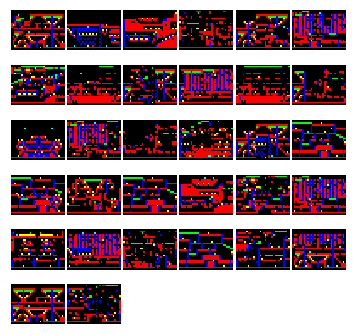

3 th evolution, score_max:0.986, score_min:0.2223,
[0.3501     0.46163846 0.63523514 0.94262874 0.86496486 0.93065556
 0.93160685 0.81091081 0.56800123 0.63245294 0.95662174 0.80256914
 0.85724286 0.91901892 0.23605506 0.98343333 0.81491481 0.97445897
 0.8751     0.96835397 0.8046977  0.69777442 0.22232222 0.94295714
 0.38676667 0.98601549 0.87219302 0.75419836 0.7201     0.80655161
 0.84220526 0.66226216]


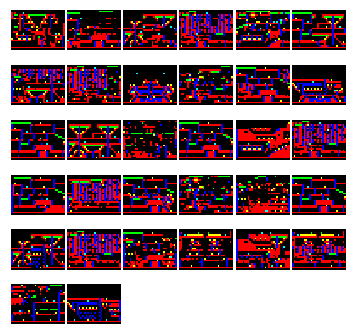

4 th evolution, score_max:0.9751, score_min:0.4873,
[0.94262874 0.56711031 0.84425584 0.90371446 0.74657887 0.48727949
 0.92781084 0.93680886 0.90253902 0.53040303 0.8801     0.83343333
 0.89883418 0.92657059 0.94127647 0.87681233 0.66226216 0.84941507
 0.9751     0.7501     0.94946709 0.94801667 0.72068824 0.61548462
 0.86373636 0.90287778 0.79497179 0.58343333 0.74334324 0.86595366
 0.91790822 0.76754186]


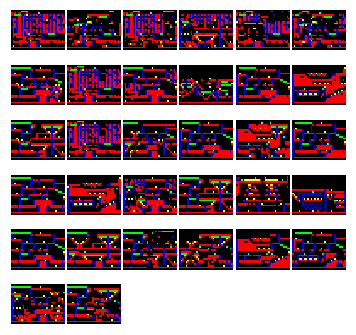

5 th evolution, score_max:0.964, score_min:0.5468,
[0.92967746 0.92115263 0.94746842 0.82768621 0.85724286 0.96395542
 0.72590645 0.88581429 0.82061282 0.75685676 0.8001     0.89295714
 0.8751     0.64782727 0.93160685 0.94946709 0.91368025 0.8751
 0.54676667 0.87961807 0.92217792 0.95955946 0.58034691 0.84820127
 0.93343333 0.79720145 0.83554304 0.68975517 0.80497805 0.81328681
 0.60304118 0.89483684]


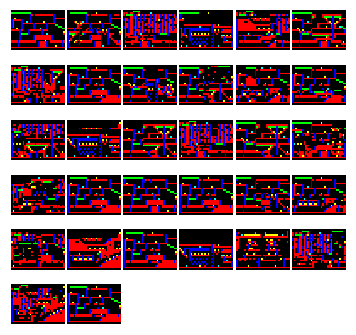

6 th evolution, score_max:0.9678, score_min:0.143,
[0.93985904 0.87681233 0.93680886 0.84893721 0.83539412 0.95598235
 0.83108592 0.92781084 0.73982603 0.9376     0.9517129  0.67042967
 0.88617595 0.86595366 0.89240769 0.96784194 0.94881795 0.85375854
 0.85907436 0.7751     0.14295714 0.67133288 0.53581429 0.9251
 0.77641579 0.75481698 0.90550541 0.9201     0.8001     0.87847838
 0.81937711 0.94057619]


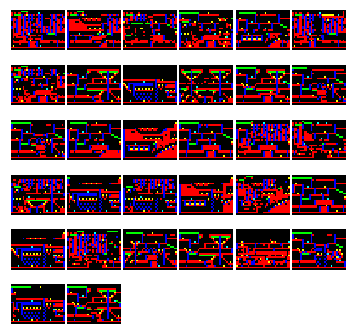

7 th evolution, score_max:0.9578, score_min:0.4097,
[0.76633377 0.73780492 0.93599744 0.42178675 0.67542468 0.82676667
 0.74708795 0.8401     0.91676667 0.94530548 0.95412299 0.70843333
 0.68125942 0.95784648 0.9126     0.94127647 0.66186471 0.83918046
 0.66676667 0.83646364 0.93912439 0.43191818 0.93253243 0.87106774
 0.5975026  0.40973855 0.95358837 0.87847838 0.80273158 0.92317692
 0.94925254 0.7501    ]


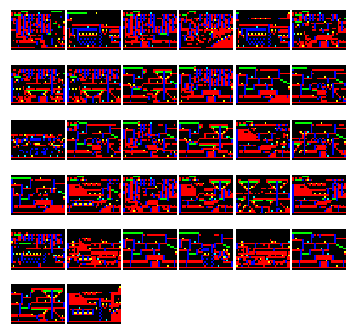

8 th evolution, score_max:0.9741, score_min:0.5069,
[0.87022987 0.96885    0.94676667 0.85565556 0.9376     0.546975
 0.63301139 0.91021236 0.7817092  0.96480588 0.73343333 0.87847838
 0.80273158 0.7655321  0.85304118 0.91054776 0.50694932 0.97412597
 0.69889518 0.87847838 0.77118434 0.97378421 0.80779231 0.87022987
 0.94295714 0.91368025 0.96163846 0.86966522 0.91054776 0.93343333
 0.70432535 0.86496486]


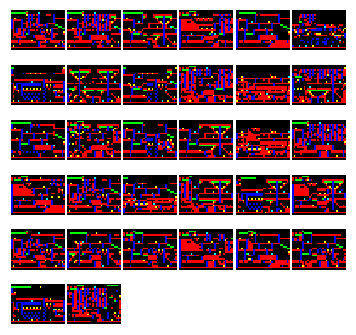

9 th evolution, score_max:0.9869, score_min:0.419,
[0.85084627 0.71631622 0.8126     0.92657059 0.55942203 0.41901892
 0.8001     0.98694211 0.74127647 0.7876     0.71242877 0.94127647
 0.97307297 0.84625385 0.79357826 0.85907436 0.73343333 0.87681233
 0.83793784 0.90919091 0.61738395 0.88617595 0.90919091 0.95464545
 0.73819524 0.87681233 0.6751     0.96113896 0.7261274  0.87189487
 0.81343333 0.97378421]


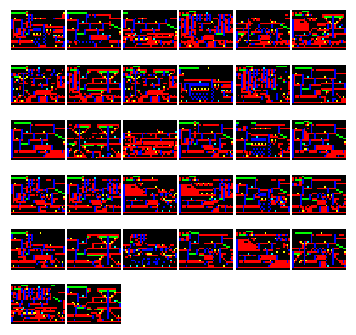

epoch: 7 ,conclusion
raw population


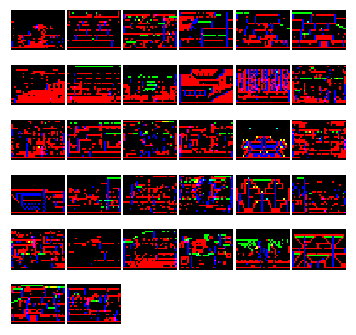

final image


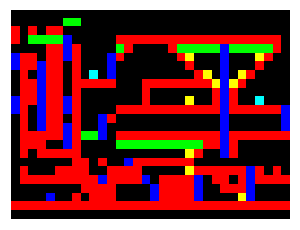

final population


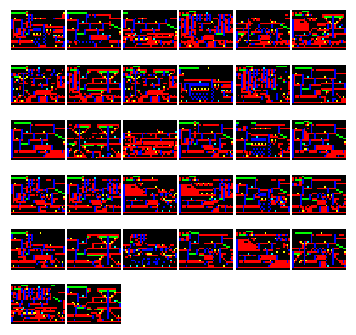

epoch: 8 ,start----------------------------------------------


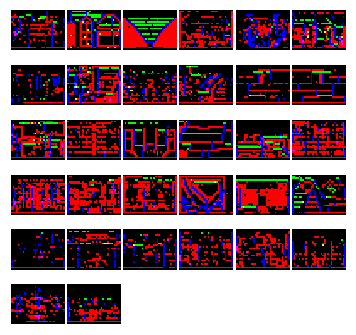

(10000, 24, 32, 5)
0 th evolution, score_max:0.9297, score_min:0.02677,
[0.92967746 0.24106386 0.43047975 0.87189487 0.88105238 0.50779231
 0.38281605 0.14127647 0.25326456 0.17958718 0.87152857 0.86676667
 0.2251     0.6558377  0.16226216 0.83554304 0.2973973  0.24295714
 0.19188082 0.04119589 0.33793784 0.11604203 0.43845616 0.42055455
 0.12205122 0.171975   0.15502958 0.48581429 0.1601     0.08870759
 0.02676667 0.02787778]
1 th evolution, score_max:0.9179, score_min:0.03906,
[0.4026974  0.86852105 0.37941034 0.8751     0.51480588 0.12653678
 0.03906104 0.90133457 0.63523514 0.43293582 0.23694211 0.3201
 0.91790822 0.34187215 0.54676667 0.51861852 0.2001     0.58237848
 0.14467831 0.6801     0.7501     0.5484871  0.67702308 0.88321688
 0.31091081 0.13245294 0.82061282 0.42178675 0.20699655 0.48873636
 0.85724286 0.21696747]


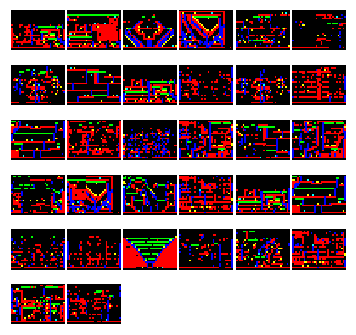

2 th evolution, score_max:0.9656, score_min:0.07052,
[0.29042258 0.42263521 0.92967746 0.63301139 0.65178539 0.77152857
 0.54176667 0.96561724 0.48202771 0.63778116 0.83918046 0.81365932
 0.80779231 0.33343333 0.8631137  0.36373636 0.6401     0.72737273
 0.96521628 0.94039851 0.20699655 0.45955946 0.8001     0.58034691
 0.45343333 0.6251     0.83343333 0.52183913 0.07052254 0.55273158
 0.7751     0.46278657]


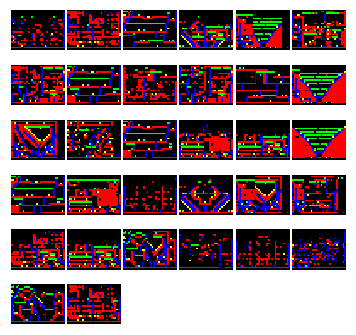

3 th evolution, score_max:0.9715, score_min:0.1759,
[0.76066338 0.82362941 0.1972831  0.66336531 0.21696747 0.66676667
 0.56531739 0.8626     0.59503671 0.51695393 0.35536316 0.77932078
 0.89199189 0.47136437 0.28419091 0.97152857 0.87681233 0.48494848
 0.36373636 0.77916977 0.28581429 0.90287778 0.17592418 0.63963488
 0.81937711 0.50756269 0.5484871  0.56933077 0.63167895 0.5751
 0.78215128 0.65227391]


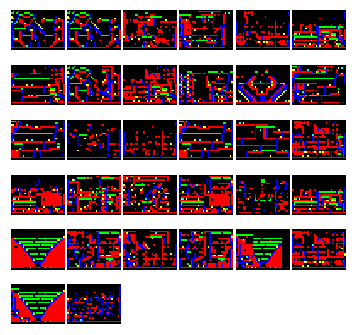

4 th evolution, score_max:0.9413, score_min:0.152,
[0.52787778 0.453225   0.93160685 0.52641579 0.93253243 0.55138205
 0.94127647 0.78092192 0.79797234 0.72849506 0.59220526 0.70977742
 0.74428605 0.69746842 0.64625385 0.50676667 0.6376     0.65442099
 0.87650449 0.53174557 0.67542468 0.28419091 0.73043708 0.66302135
 0.90371446 0.26037397 0.75767576 0.79421765 0.55892353 0.83343333
 0.15199873 0.75565556]


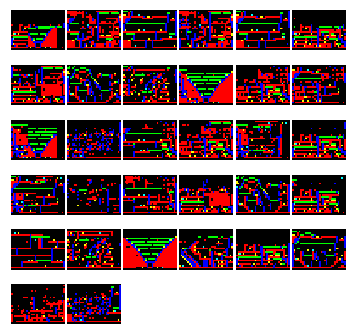

5 th evolution, score_max:0.9475, score_min:0.1312,
[0.63646364 0.65227391 0.76325789 0.86085949 0.60879565 0.5863069
 0.74203548 0.83571644 0.19490519 0.66676667 0.74334324 0.35536316
 0.26446782 0.7876     0.50627284 0.79230779 0.71438571 0.94746842
 0.73982603 0.7626     0.73427722 0.66676667 0.86756988 0.82676667
 0.63167895 0.58251758 0.80962381 0.57313371 0.72068824 0.13124754
 0.6876     0.9001    ]


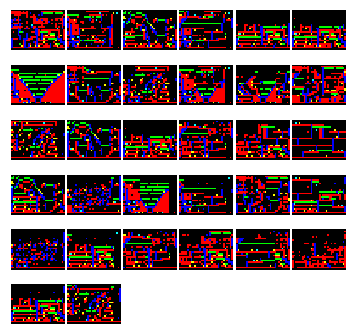

6 th evolution, score_max:0.9037, score_min:0.4569,
[0.90371446 0.80779231 0.52183913 0.84347349 0.69873014 0.77641579
 0.60304118 0.59100909 0.6876     0.62328841 0.68549326 0.89020989
 0.82726049 0.47307297 0.59766098 0.83126883 0.81954444 0.67787778
 0.68841169 0.74676667 0.69454444 0.7196122  0.6876     0.54032989
 0.61852105 0.89051096 0.79528072 0.79462055 0.89483684 0.48061948
 0.81700141 0.45689012]


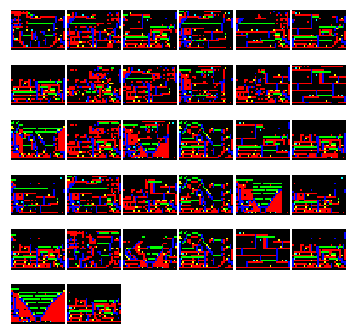

7 th evolution, score_max:0.936, score_min:0.4305,
[0.75619756 0.43047975 0.62205122 0.6626     0.6401     0.47445897
 0.67115263 0.82867143 0.55138205 0.83960617 0.63086923 0.5061241
 0.90707674 0.49421765 0.7762194  0.49377089 0.61121111 0.87888788
 0.71242877 0.7501     0.59220526 0.60283973 0.63167895 0.93599744
 0.7261274  0.4376     0.65832785 0.84755763 0.91035641 0.90133457
 0.84732222 0.7196122 ]


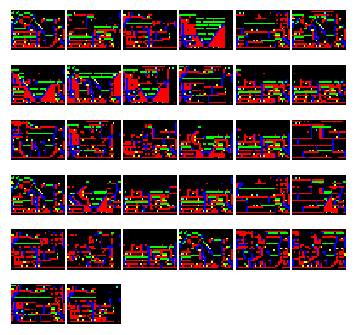

8 th evolution, score_max:0.946, score_min:0.3907,
[0.7501     0.86180213 0.50584713 0.50627284 0.68191818 0.72068824
 0.390725   0.70940233 0.47378421 0.8751     0.93065556 0.82362941
 0.91790822 0.71121111 0.62172162 0.58471538 0.66676667 0.41676667
 0.65863659 0.73343333 0.75872069 0.72141148 0.71438571 0.63275306
 0.65227391 0.94604595 0.5626     0.8751     0.86373636 0.74368974
 0.86756988 0.72982973]


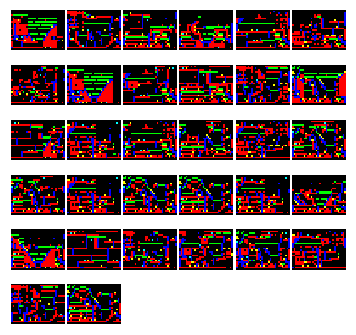

9 th evolution, score_max:0.9495, score_min:0.1572,
[0.609475   0.90799474 0.68191818 0.41870465 0.7001     0.7973973
 0.84625385 0.82936829 0.94946709 0.73180732 0.15724286 0.80892353
 0.8975359  0.90150845 0.76066338 0.40919091 0.72982973 0.90332581
 0.67282727 0.64715882 0.67867143 0.53174557 0.67174179 0.67751935
 0.35830896 0.7038037  0.83918046 0.71024493 0.63865422 0.62676667
 0.74295714 0.6251    ]


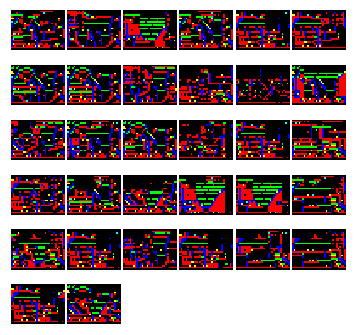

epoch: 8 ,conclusion
raw population


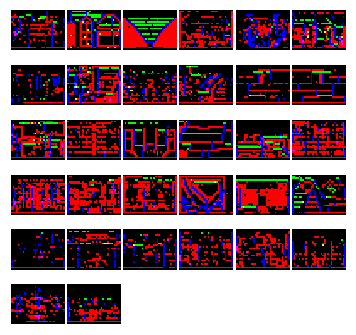

final image


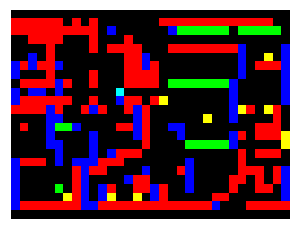

final population


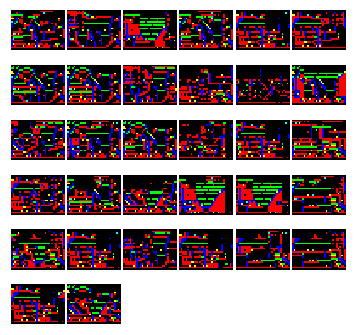

epoch: 9 ,start----------------------------------------------


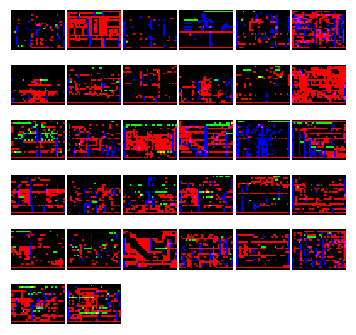

(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.02607,
[0.28388378 0.37984684 0.81491481 0.51121111 1.0001     0.90150845
 0.36373636 0.73539412 0.09648554 0.84067971 0.2028027  0.52317692
 0.90919091 0.21676667 0.17470317 0.42867143 0.08229178 0.67356939
 0.17401304 0.03906104 0.13646364 0.02607403 0.95131951 0.05273158
 0.04421765 0.1548619  0.16893117 0.21343333 0.30497805 0.07152857
 0.07052254 0.02607403]
1 th evolution, score_max:0.9886, score_min:0.04661,
[0.94392022 0.95131951 0.95900411 0.51229512 0.62800698 0.2973973
 0.92115263 0.94946709 0.10853373 0.08443735 0.11373636 0.38564217
 0.86056512 0.24625385 0.31157541 0.41870465 0.50627284 0.98860575
 0.16676667 0.73982603 0.6801     0.20522821 0.08460704 0.37657059
 0.828225   0.90371446 0.34338358 0.80962381 0.28368209 0.87681233
 0.04661163 0.08443735]


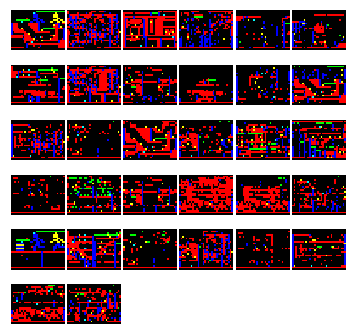

2 th evolution, score_max:1.0, score_min:0.1796,
[0.86373636 0.88471538 0.98775432 0.34625385 0.66676667 0.93680886
 0.42676667 0.4001     0.27951176 0.52951176 0.92317692 0.81438571
 0.1885058  0.20997654 0.84771905 0.98873636 0.94262874 0.57343333
 0.61121111 0.78898889 0.46386812 1.0001     0.93065556 0.19111124
 0.43253243 0.88245294 0.17958718 0.68431053 0.90150845 0.38581429
 0.52248806 0.93065556]


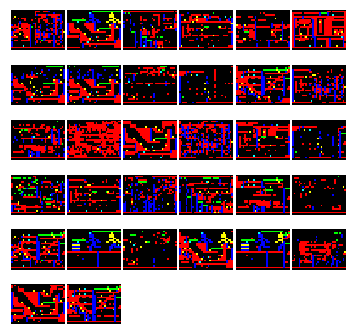

3 th evolution, score_max:1.0, score_min:0.06907,
[0.92317692 0.6501     0.5891411  0.56531739 0.37691159 0.8126
 1.0001     0.2501     1.0001     0.84858485 0.67174179 0.84385
 0.9001     0.78661685 0.53343333 0.78135    0.4501     0.37847838
 1.0001     0.17343333 0.53668537 0.91576265 0.91964023 0.16226216
 0.35221268 0.93599744 0.06906552 0.18319859 0.59503671 0.88069701
 0.92967746 0.72473768]


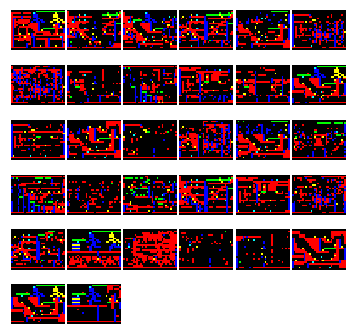

4 th evolution, score_max:0.9891, score_min:0.08343,
[0.88742394 0.95955946 0.55706203 0.38676667 0.59503671 0.91149241
 0.52064795 0.82099552 0.77787778 0.93516494 0.37359398 0.65724286
 0.5201     0.5916493  0.98911099 0.79462055 0.34187215 0.08343333
 0.7629866  0.68581429 0.67542468 0.51525152 0.90133457 0.83343333
 0.4251     0.83554304 0.84156341 0.30874198 0.48158148 0.17401304
 0.91790822 0.83571644]


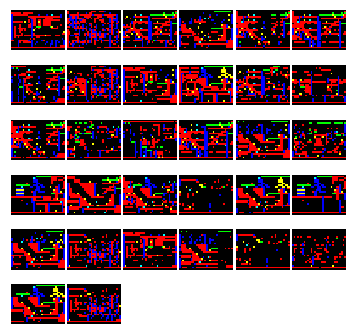

5 th evolution, score_max:0.9541, score_min:0.297,
[0.85724286 0.36121111 0.95412299 0.34858485 0.83793784 0.95131951
 0.296975   0.94057619 0.77641579 0.73427722 0.87847838 0.91901892
 0.83343333 0.7376     0.36273736 0.6001     0.94907959 0.66163846
 0.6876     0.41473415 0.74657887 0.92967746 0.92602593 0.82904737
 0.54295714 0.80256914 0.86429753 0.76480588 0.32404366 0.69343333
 0.62172162 0.94454444]


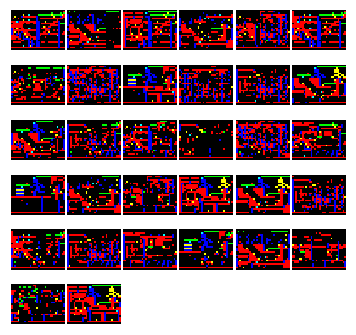

6 th evolution, score_max:0.9678, score_min:0.3805,
[0.94262874 0.89483684 0.78957368 0.38053478 0.72951176 0.91473415
 0.3878551  0.78504624 0.88719677 0.78471538 0.94946709 0.9601
 0.76933077 0.93985904 0.84517042 0.96784194 0.91473415 0.96062632
 0.8626     0.75334675 0.82442432 0.76398889 0.96163846 0.75959367
 0.66676667 0.71438571 0.91035641 0.4301     0.77932078 0.60283973
 0.7001     0.8631137 ]


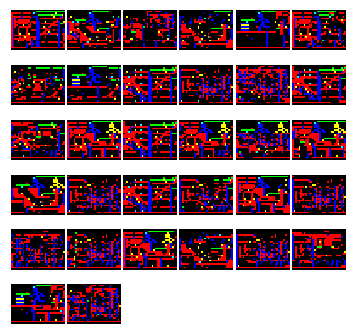

7 th evolution, score_max:0.9751, score_min:0.3897,
[0.92563191 0.82201781 0.83126883 0.79817692 0.38971039 0.92967746
 0.9751     0.92657059 0.89199189 0.87106774 0.96438571 0.96351463
 0.8876     0.64715882 0.58581429 0.93856154 0.87311587 0.96639213
 0.9001     0.8751     0.85724286 0.92641579 0.96163846 0.86216897
 0.85536316 0.94454444 0.9626     0.66676667 0.89883418 0.87152857
 0.79771905 0.93253243]


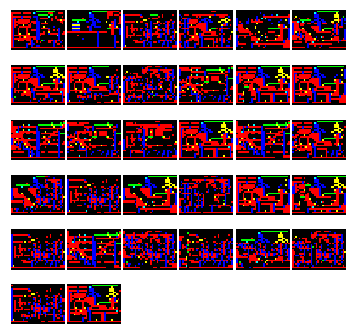

8 th evolution, score_max:0.9876, score_min:0.4723,
[0.87189487 0.76605745 0.95131951 0.9876     0.7973973  0.70977742
 0.90919091 0.97412597 0.95843333 0.89715882 0.87814878 0.74334324
 0.74203548 0.7655321  0.89343333 0.96933077 0.78491013 0.74657887
 0.96062632 0.79462055 0.94295714 0.72737273 0.82726049 0.96163846
 0.47232222 0.88245294 0.73343333 0.55138205 0.7973973  0.89403939
 0.8751     0.89199189]


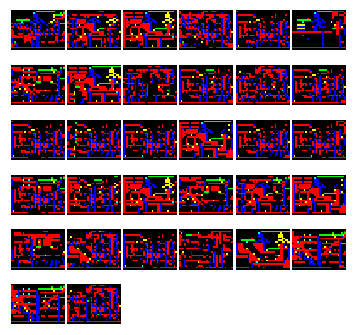

9 th evolution, score_max:0.959, score_min:0.2044,
[0.7722519  0.78957368 0.84347349 0.72951176 0.57152857 0.78471538
 0.94815195 0.91121111 0.77787778 0.77037027 0.74035974 0.5953381
 0.95900411 0.91149241 0.88515747 0.93985904 0.93680886 0.84625385
 0.95071728 0.75334675 0.20440108 0.95708925 0.83126883 0.7827087
 0.86496486 0.83108592 0.7751     0.73923043 0.8876     0.74676667
 0.74657887 0.92951176]


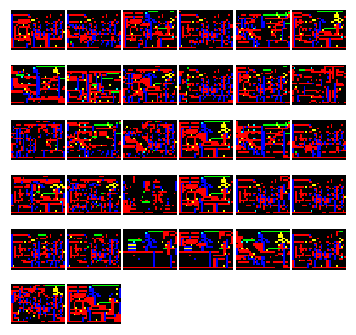

epoch: 9 ,conclusion
raw population


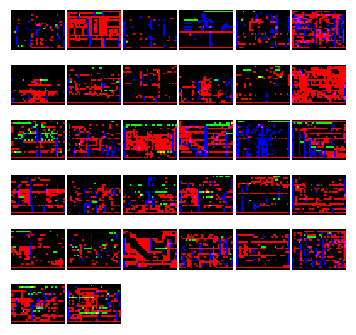

final image


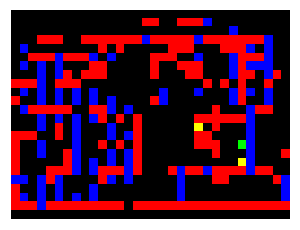

final population


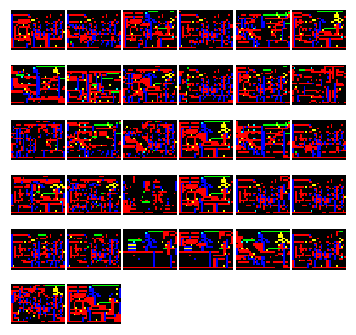

------------final round------------
(10000, 24, 32, 5)
0 th evolution, score_max:1.0, score_min:0.8637,
[0.91576265 0.95394615 0.92763623 0.91438571 1.0001     0.9201
 0.86373636 0.95900411 0.93253243 0.93912439]
1 th evolution, score_max:0.9862, score_min:0.8825,
[0.9126     0.96163846 0.95784648 0.98621111 0.9601     0.88581429
 0.88245294 0.95412299 0.98370656 0.94295714]


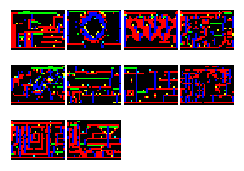

2 th evolution, score_max:1.0, score_min:0.8603,
[0.96163846 0.98999899 0.86031505 0.98790488 1.0001     0.91901892
 0.91870465 0.98581429 0.98494848 0.88774045]


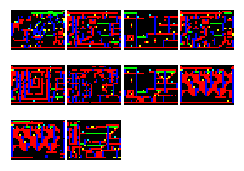

3 th evolution, score_max:1.0, score_min:0.8609,
[0.98873636 1.0001     0.95248095 0.95662174 0.86085949 0.87702308
 1.0001     0.96933077 1.0001     0.92115263]


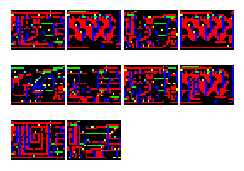

4 th evolution, score_max:0.959, score_min:0.6438,
[0.91901892 0.95900411 0.94881795 0.95724286 0.9383716  0.95394615
 0.92692927 0.84715882 0.8751     0.64377816]


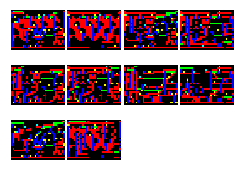

5 th evolution, score_max:1.0, score_min:0.5601,
[0.94604595 0.94196047 0.89562239 0.86966522 0.87664321 0.95900411
 0.5601     0.9788234  1.0001     0.89562239]


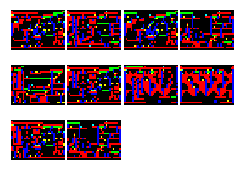

6 th evolution, score_max:1.0, score_min:0.7392,
[1.0001     0.89865072 0.93949394 0.73923043 0.97629048 0.97478354
 1.0001     0.89782727 0.98560725 0.85724286]


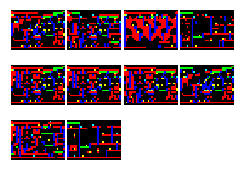

7 th evolution, score_max:1.0, score_min:0.5396,
[0.9001     0.93113448 0.93694211 0.7251     1.0001     0.72867143
 0.93680886 0.53957368 0.95464545 0.9601    ]


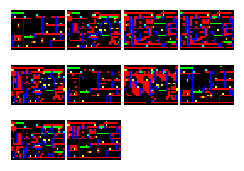

8 th evolution, score_max:0.9751, score_min:0.573,
[0.9751     0.57301667 0.93253243 0.7501     0.90287778 0.95614396
 0.96163846 0.94328182 0.90779231 0.94392022]


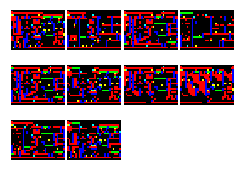

9 th evolution, score_max:0.9873, score_min:0.261,
[0.98727949 0.90550541 0.91676667 0.91473415 0.92055455 0.87351772
 0.8126     0.92951176 0.26096957 0.90550541]


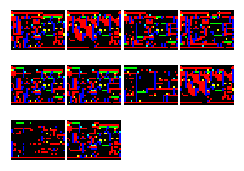

10 th evolution, score_max:0.9745, score_min:0.2585,
[0.7501     0.65635    0.38038169 0.25852697 0.93912439 0.92867143
 0.97445897 0.64377816 0.60879565 0.95784648]


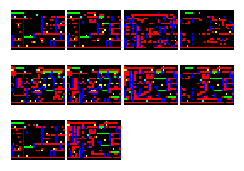

11 th evolution, score_max:0.986, score_min:0.3612,
[0.9383716  0.90394615 0.40287778 0.98601549 0.81717317 0.73427722
 0.36121111 0.58581429 0.94212899 0.63646364]


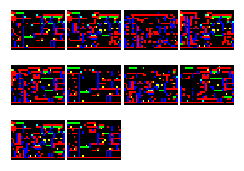

12 th evolution, score_max:0.986, score_min:0.2648,
[0.57702308 0.93488261 0.93680886 0.94039851 0.68125942 0.98601549
 0.96480588 0.26480588 0.58546585 0.7261274 ]


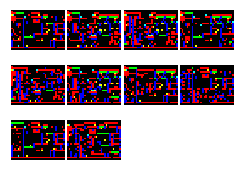

13 th evolution, score_max:0.9572, score_min:0.3515,
[0.95412299 0.6001     0.86676667 0.35145135 0.6501     0.91186471
 0.86085949 0.36595366 0.95724286 0.64295714]


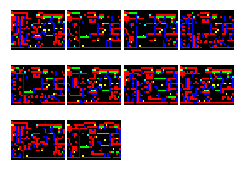

14 th evolution, score_max:0.9738, score_min:0.3591,
[0.93431053 0.97378421 0.95464545 0.46763247 0.76633377 0.50659351
 0.94212899 0.35907436 0.4626     0.50676667]


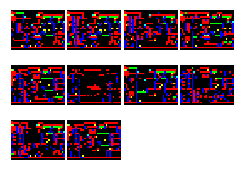

15 th evolution, score_max:0.9546, score_min:0.3838,
[0.85195185 0.65832785 0.94295714 0.56766757 0.95464545 0.49343333
 0.94633656 0.38382093 0.3969254  0.73819524]


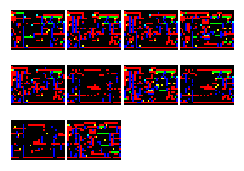

16 th evolution, score_max:0.9445, score_min:0.5508,
[0.9201     0.81548462 0.93985904 0.93516494 0.90635    0.92415063
 0.87189487 0.62830513 0.94454444 0.55082464]


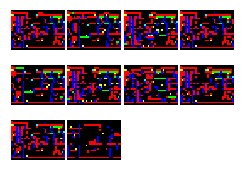

17 th evolution, score_max:0.9842, score_min:0.6453,
[0.87189487 0.7805878  0.85145135 0.89403939 0.83793784 0.98422698
 0.83554304 0.66226216 0.64526129 0.79176667]


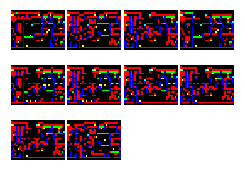

18 th evolution, score_max:0.9738, score_min:0.6112,
[0.95304118 0.92781084 0.88321688 0.82442432 0.9376     0.7626
 0.61121111 0.97378421 0.88245294 0.96212532]


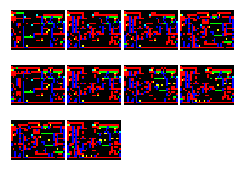

19 th evolution, score_max:0.9297, score_min:0.4825,
[0.7038037  0.62696567 0.92967746 0.82618696 0.80732892 0.87922088
 0.91473415 0.71438571 0.84517042 0.48245294]


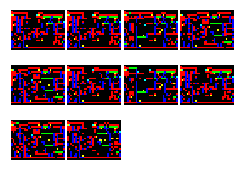

20 th evolution, score_max:0.9342, score_min:0.5812,
[0.68431053 0.93416593 0.64644146 0.83554304 0.84136984 0.73343333
 0.58118108 0.87814878 0.91149241 0.63167895]


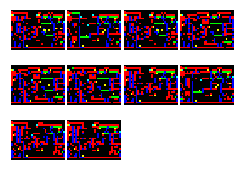

21 th evolution, score_max:0.9439, score_min:0.5251,
[0.8001     0.94392022 0.9251     0.62830513 0.66676667 0.69777442
 0.5251     0.59269259 0.81977213 0.89295714]


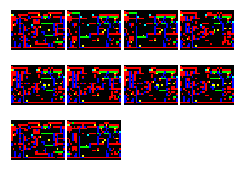

22 th evolution, score_max:0.8956, score_min:0.4596,
[0.87366322 0.67867143 0.45955946 0.70843333 0.89562239 0.84220526
 0.71651791 0.67577568 0.5126     0.64566962]


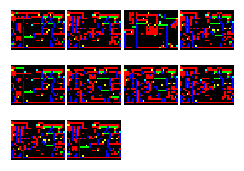

23 th evolution, score_max:0.964, score_min:0.1563,
[0.40635    0.77152857 0.76821594 0.48727949 0.57327073 0.96395542
 0.65863659 0.56588947 0.6126     0.15635   ]


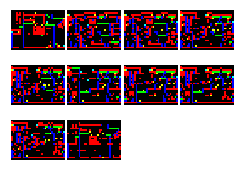

24 th evolution, score_max:0.919, score_min:0.4517,
[0.4517129  0.55218333 0.67911235 0.6120403  0.91901892 0.67152857
 0.67042967 0.76754186 0.66676667 0.52469016]


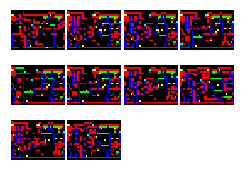

25 th evolution, score_max:0.7068, score_min:0.4206,
[0.62078966 0.54226867 0.70676667 0.7001     0.58833529 0.50676667
 0.67702308 0.42055455 0.52867143 0.4626    ]


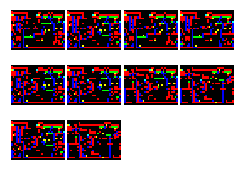

26 th evolution, score_max:0.6924, score_min:0.3974,
[0.62131212 0.69240769 0.63023699 0.61548462 0.45343333 0.55218333
 0.46278657 0.62696567 0.46163846 0.39736027]


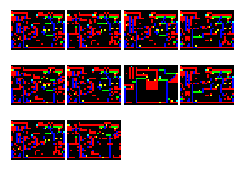

27 th evolution, score_max:0.6668, score_min:0.4408,
[0.5891411  0.60250964 0.60283973 0.4940759  0.52951176 0.66676667
 0.65161515 0.51398889 0.6001     0.44077797]


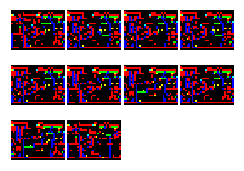

28 th evolution, score_max:0.6758, score_min:0.5001,
[0.61738395 0.52469016 0.67577568 0.5001     0.6376     0.52574103
 0.5506618  0.65442099 0.64483684 0.58984359]


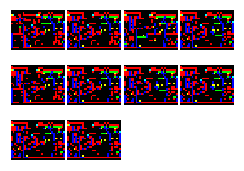

29 th evolution, score_max:0.7287, score_min:0.4178,
[0.57544247 0.59711493 0.59687419 0.62035316 0.72867143 0.49460549
 0.5444038  0.41782152 0.7013987  0.56480588]


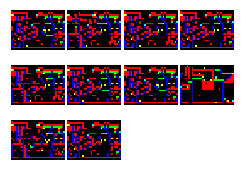

30 th evolution, score_max:0.9115, score_min:0.4472,
[0.91149241 0.57152857 0.44715882 0.56726418 0.59220526 0.51695393
 0.55182414 0.58118108 0.58676667 0.5001    ]


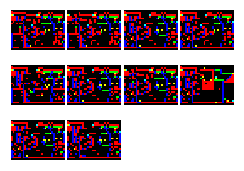

31 th evolution, score_max:0.9438, score_min:0.1729,
[0.60503827 0.50779231 0.59046145 0.17293951 0.61981831 0.59560562
 0.60820811 0.64644146 0.94376197 0.36373636]


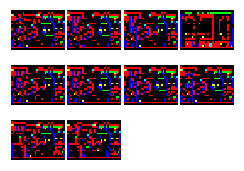

32 th evolution, score_max:0.6858, score_min:0.1626,
[0.55444783 0.30389747 0.53419091 0.53856154 0.34256575 0.55138205
 0.6001     0.68581429 0.1626     0.60536316]


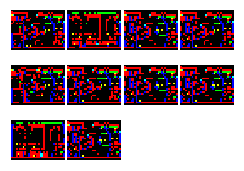

33 th evolution, score_max:0.6448, score_min:0.1668,
[0.63245294 0.61738395 0.5916493  0.16676667 0.40253902 0.3909046
 0.49263731 0.61807753 0.64483684 0.55565556]


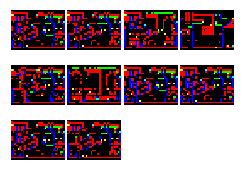

34 th evolution, score_max:0.6317, score_min:0.1539,
[0.59269259 0.60237273 0.57456809 0.15394615 0.5626     0.63167895
 0.32152857 0.62172162 0.5626     0.55304118]


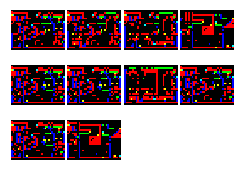

35 th evolution, score_max:0.8954, score_min:0.4936,
[0.64798732 0.89544884 0.49360649 0.66676667 0.65724286 0.6558377
 0.5876     0.69777442 0.58833529 0.63502063]


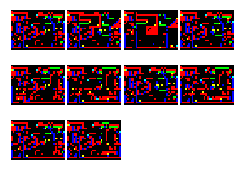

36 th evolution, score_max:0.805, score_min:0.3847,
[0.57152857 0.80497805 0.57327073 0.5601     0.38471538 0.42317692
 0.58436966 0.6970697  0.43539412 0.62328841]


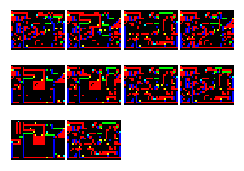

37 th evolution, score_max:0.8653, score_min:0.3811,
[0.82988723 0.54295714 0.5975026  0.59312326 0.38105238 0.67115263
 0.60879565 0.86526854 0.53343333 0.40253902]


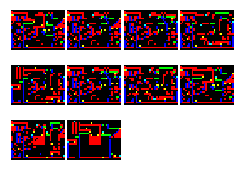

38 th evolution, score_max:0.8422, score_min:0.4349,
[0.65178539 0.84220526 0.4501     0.6836443  0.62800698 0.71631622
 0.70843333 0.6098561  0.43488261 0.45724286]


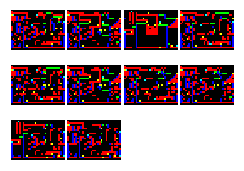

39 th evolution, score_max:0.8876, score_min:0.3376,
[0.53581429 0.63424634 0.40550541 0.52183913 0.3376     0.8876
 0.82288481 0.63390282 0.3751     0.72982973]


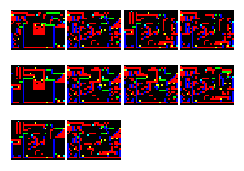

raw population


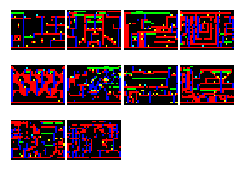

final image


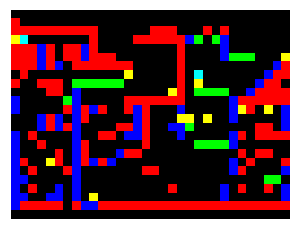

final population


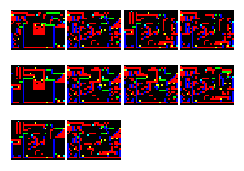

final level candate


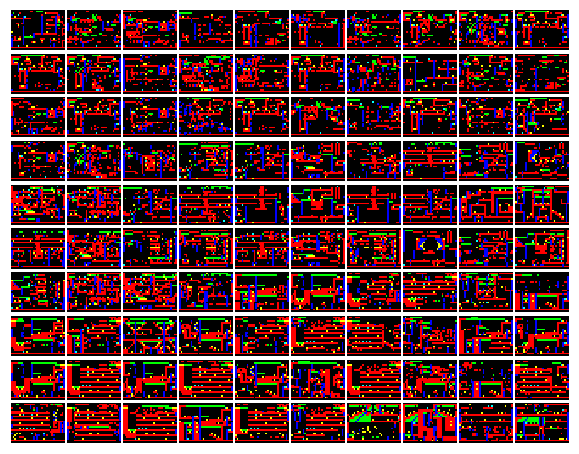

In [14]:
#evo param
evo_in_path = "e://python3/vae_v3.npy"
crossover_rate = 0.9
mutate_rate = 0.1
n_population = 32
n_iterations = 10   #total iteration = (9+1)*3=30  #time complexity = 30*3*9* O(Astar)= (np*ni)**2 *astar
#------------------------------------------------------------------
rawset = np.load(evo_in_path)
np.random.shuffle(rawset)

#data = np.random.randint(0,2,size=(n_population,DNA_size)).astype(np.int8)
extra_set = []
final_set = []
st = 0

for i in range(10):  #n_population
    print('epoch:',i,',start----------------------------------------------')
    idx = np.random.choice(np.arange(rawset.shape[0]), size=n_population, replace=False)
    img_in = rawset[idx]
    Util.disp_images(img_in) 
    gene = Util.img2gene(img_in)   
    ga = Generic(gene,rawset=rawset,crossover_rate=crossover_rate,mutate_rate = mutate_rate,n_population=n_population,
                  DNA_size=gb_w*gb_h*gb_c, n_iterations = n_iterations)
    ga.evolution()
    print('epoch:',i,',conclusion')
    print('raw population')
    Util.disp_images(img_in) 
    print('final image')
    Util.disp_images(ga.best_person.reshape([1,-1]),figsize=(5,4)) 
    print('final population')
    Util.disp_images(ga.population) 
    final_set,st = (np.vstack((final_set,ga.population)),1) if st==1 else (ga.population,1)
    extra_set.append(ga.best_person)
    
print('------------final round------------')
ga = Generic(np.array(extra_set),rawset=rawset,crossover_rate=crossover_rate,mutate_rate = mutate_rate,n_population=min(len(extra_set),n_population),
                  DNA_size=gb_w*gb_h*gb_c, n_iterations = n_iterations*4)
ga.evolution()

print('raw population')
Util.disp_images(np.array(extra_set)) 

print('final image')
Util.disp_images(ga.best_person.reshape([1,-1]),figsize=(5,4)) 
print('final population')
Util.disp_images(ga.population) 

final_set = np.vstack((final_set,ga.population))
print('final level candate')
Util.disp_images(np.array(final_set).reshape([-1,gb_w*gb_h*gb_c]),figsize=(10.0, 8.0)) 
np.save("evolution_v3",np.array(final_set).reshape([-1,gb_w*gb_h*gb_c]),allow_pickle=False,fix_imports=True)


(330, 3840)


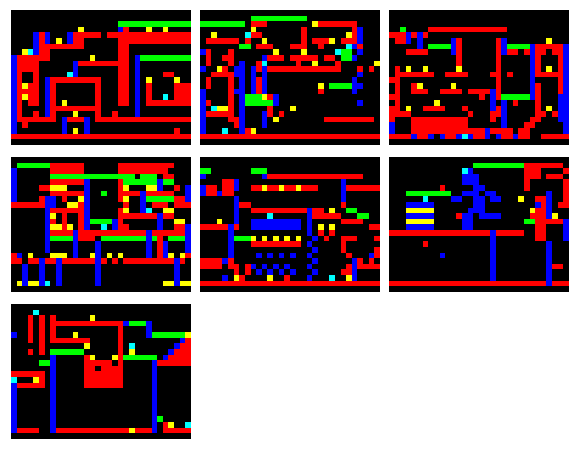

In [26]:
sth = np.load("e://python3/evolution_v3.npy")
print(sth.shape)
#np.random.shuffle(sth)
_ = disp_images(sth[[48,29,137,203,240,314,324]],figsize=(10.0, 8.0))

(7, 24, 32, 5)


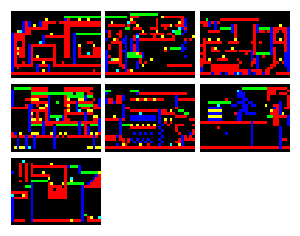

In [30]:
wanted = sth[[48,29,137,203,240,314,324]].reshape([-1,gb_w,gb_h,gb_c])
print(wanted.shape)
np.save("VAE",wanted,allow_pickle=False,fix_imports=True)
test = np.load("e://python3/VAE.npy")
_ = disp_images(test,figsize=(5.0, 4.0))